# 1. Baseline Models for Real Estate Price Prediction – Evaluation and Insights

This notebook focuses on building and comparing baseline machine learning models to predict real estate prices using tabular property data.

We aim to evaluate the strengths and limitations of different regression approaches, such as:

- **Linear Regression**: as a simple interpretable baseline.
- **Random Forest**: a powerful ensemble method for handling non-linearities.
- **Reduced Random Forest**: using only the top features to assess the impact of dimensionality reduction.

For each model, we:

- Train on the available features (`bedroomCount`, `surface`, `postCode`, etc.).
- Predict the target variable: **raw price** in euros.
- Evaluate performance using MAE, RMSE, and R<sup>2</sup> metrics.
- Visualize residuals and prediction errors using 3 diagnostic plots:
  - Residuals vs Predicted
  - Residual Distribution
  - Predicted vs Actual

>  Key insight: The raw price target leads to high error due to extreme variance and lack of normalization. This will be addressed in future notebooks using `price_per_m<sup>2</sup>`, segmentation, and better feature engineering.

This notebook serves as a foundation for improving model robustness and exploring advanced ML techniques in future steps.

# Load dataset and clean
- Step 1 – Drop columns with too many missing value
- Step 2 – Keep only rows with at least 70% non-missing values
- Step 3 – Remove outliers based on key numerical columns

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# === Load dataset ===
df = pd.read_csv("../data/immoweb_real_estate.csv")

# === Step 1 – Drop columns with too many missing values ===
missing_threshold = 0.5

# Total number of columns before cleaning
initial_col_count = df.shape[1]

# Identify columns to drop (those with >50% missing values)
cols_to_drop = df.columns[df.isnull().mean() > missing_threshold]
dropped_col_count = len(cols_to_drop)

# Drop columns
df_cleaned = df.drop(columns=cols_to_drop)

# Count remaining columns
remaining_col_count = df_cleaned.shape[1]

# Display column cleaning summary
print("\n=== Drop columns with a missing threashold = 0.5 ===")
print(f"Initial number of columns: {initial_col_count}")
print(f"Number of columns dropped (>50% missing): {dropped_col_count}")
print(f"Remaining columns: {remaining_col_count}")

print("\nColumns dropped:")
for col in cols_to_drop:
    print(f"  • {col}")

# === Step 2 – Keep only rows with at least 70% non-missing values ===
min_required = int(df_cleaned.shape[1] * 0.7)  # Minimum non-null values required per row
before_shape = df_cleaned.shape

# Drop rows below threshold
df_cleaned = df_cleaned.dropna(thresh=min_required)
after_shape = df_cleaned.shape

# Display only rows with at least 70% non-missing values
print("\n=== Keep only rows with at least 70% non-missing values ===")
print(f"Threshold: keep rows with ≥70% non-missing values (at least {min_required} non-null columns)")
print(f"Rows before cleaning: {before_shape[0]}")
print(f"Rows after cleaning:  {after_shape[0]}")
print(f"Rows removed:         {before_shape[0] - after_shape[0]}")

# === Step 3 – Remove outliers based on key numerical columns ===
df = df_cleaned.copy()

# Apply filters to remove extreme outliers
df_no_outliers = df[
    (df["price"] >= 50000) & (df["price"] <= 1_200_000) &
    (df["habitableSurface"] >= 15) & (df["habitableSurface"] <= 500) &
    (df["bedroomCount"] >= 0) & (df["bedroomCount"] <= 10) &
    (df["bathroomCount"] >= 0) & (df["bathroomCount"] <= 5) &
    (df["toiletCount"] >= 0) & (df["toiletCount"] <= 5) &
    (df["buildingConstructionYear"] >= 1850) & (df["buildingConstructionYear"] <= 2025)
]

# Display final Cleaning Summary without outliers
print("\n=== Final Cleaning Summary (No outliers) ===")
print("Outlier filtering applied on selected columns.")
print(f"Rows before outlier removal: {df.shape[0]}")
print(f"Rows after outlier removal:  {df_no_outliers.shape[0]}")
print(f"Rows removed as outliers:    {df.shape[0] - df_no_outliers.shape[0]}")

# === Export cleaned dataset ===
df_no_outliers.to_csv("../data/immoweb_real_estate_cleaned_dataset.csv", index=False)
print("Cleaned dataset saved to: '../data/immoweb_real_estate_cleaned_dataset.csv'")

# Save as Excel
excel_path = "../data/immoweb_real_estate_ml_ready_sample10.xlsx"
df_no_outliers.head(10).to_excel(excel_path, index=False)
print(f"Excel sample file saved to: {excel_path}")



=== Drop columns with a missing threashold = 0.5 ===
Initial number of columns: 53
Number of columns dropped (>50% missing): 31
Remaining columns: 22

Columns dropped:
  • roomCount
  • monthlyCost
  • hasAttic
  • hasBasement
  • hasDressingRoom
  • diningRoomSurface
  • hasDiningRoom
  • floorCount
  • streetFacadeWidth
  • hasLift
  • hasHeatPump
  • hasPhotovoltaicPanels
  • hasThermicPanels
  • kitchenSurface
  • landSurface
  • livingRoomSurface
  • hasBalcony
  • hasGarden
  • gardenSurface
  • gardenOrientation
  • parkingCountIndoor
  • parkingCountOutdoor
  • hasAirConditioning
  • hasArmoredDoor
  • hasVisiophone
  • hasOffice
  • hasSwimmingPool
  • hasFireplace
  • terraceSurface
  • terraceOrientation
  • accessibleDisabledPeople

=== Keep only rows with at least 70% non-missing values ===
Threshold: keep rows with ≥70% non-missing values (at least 15 non-null columns)
Rows before cleaning: 80368
Rows after cleaning:  70125
Rows removed:         10243

=== Final Cleaning

## Load and Explore the Dataset

- Load dataset
- df.head(), df.info(), df.describe()
- Visual summary: distributions, correlations, missing values

In [ ]:
# Load and Explore the Dataset

# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Load the cleaned dataset
df = pd.read_csv("../data/immoweb_real_estate_cleaned_dataset.csv")

# Display basic structure
print("Dataset loaded successfully!")
print("Shape:", df.shape)

# Display the first rows
df.head()



Dataset loaded successfully!
Shape: (70125, 22)


,Unnamed: 0,id,url,type,subtype,bedroomCount,bathroomCount,province,locality,postCode,...,buildingConstructionYear,facedeCount,floodZoneType,heatingType,kitchenType,hasLivingRoom,toiletCount,hasTerrace,epcScore,price
0,0,20661494.0,https://www.immoweb.be/en/classified/apartment...,APARTMENT,APARTMENT,2.0,1.0,Brussels,Etterbeek,1040,...,2004.0,1.0,NON_FLOOD_ZONE,GAS,SEMI_EQUIPPED,True,1.0,True,C,399000.0
1,1,20647642.0,https://www.immoweb.be/en/classified/house/for...,HOUSE,HOUSE,4.0,2.0,Brussels,Etterbeek,1040,...,1910.0,2.0,NON_FLOOD_ZONE,FUELOIL,INSTALLED,True,3.0,True,E,895000.0
2,2,20644816.0,https://www.immoweb.be/en/classified/apartment...,APARTMENT,APARTMENT,2.0,1.0,Brussels,Etterbeek,1040,...,1970.0,2.0,NaN,FUELOIL,HYPER_EQUIPPED,True,1.0,True,F,465000.0
3,3,20659813.0,https://www.immoweb.be/en/classified/apartment...,APARTMENT,APARTMENT,2.0,2.0,Brussels,Bruxelles,1040,...,2018.0,NaN,RECOGNIZED_FLOOD_ZONE,GAS,HYPER_EQUIPPED,True,2.0,True,B,590000.0
4,4,20633249.0,https://www.immoweb.be/en/classified/flat-stud...,APARTMENT,FLAT_STUDIO,1.0,1.0,Brussels,Etterbeek,1040,...,1906.0,2.0,NON_FLOOD_ZONE,GAS,INSTALLED,NaN,1.0,NaN,E,289000.0


In [4]:
# Check column types and non-null counts
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70125 entries, 0 to 70124
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                70125 non-null  int64  
 1   id                        70125 non-null  float64
 2   url                       70125 non-null  object 
 3   type                      70125 non-null  object 
 4   subtype                   70125 non-null  object 
 5   bedroomCount              68602 non-null  float64
 6   bathroomCount             64357 non-null  float64
 7   province                  70125 non-null  object 
 8   locality                  70125 non-null  object 
 9   postCode                  70125 non-null  int64  
 10  habitableSurface          64518 non-null  float64
 11  buildingCondition         55882 non-null  object 
 12  buildingConstructionYear  47867 non-null  float64
 13  facedeCount               51040 non-null  float64
 14  floodZ

In [5]:
# Summary statistics for numerical columns
df.describe()



,Unnamed: 0,id,bedroomCount,bathroomCount,postCode,habitableSurface,buildingConstructionYear,facedeCount,toiletCount,price
count,70125.000000,7.012500e+04,68602.000000,64357.000000,70125.000000,64518.000000,47867.000000,51040.000000,54311.000000,7.012100e+04
mean,207851.276421,1.973031e+07,3.007376,1.427164,5178.973533,177.267755,1977.814005,2.820905,1.804993,4.502022e+05
std,105816.861086,2.611911e+06,1.723670,4.629853,3048.108181,836.909209,41.403230,0.943971,8.472308,5.109523e+05
min,0.000000,1.882546e+06,1.000000,1.000000,1000.000000,6.000000,1753.000000,1.000000,1.000000,1.499900e+04
25%,181320.000000,2.038088e+07,2.000000,1.000000,2288.000000,94.000000,1957.000000,2.000000,1.000000,2.350000e+05
50%,234162.000000,2.053773e+07,3.000000,1.000000,4624.000000,140.000000,1979.000000,3.000000,2.000000,3.300000e+05
75%,256347.000000,2.061784e+07,4.000000,2.000000,8400.000000,200.000000,2016.000000,4.000000,2.000000,4.800000e+05
max,446550.000000,2.066439e+07,100.000000,1146.000000,9992.000000,185347.000000,2055.000000,86.000000,1958.000000,1.500000e+07


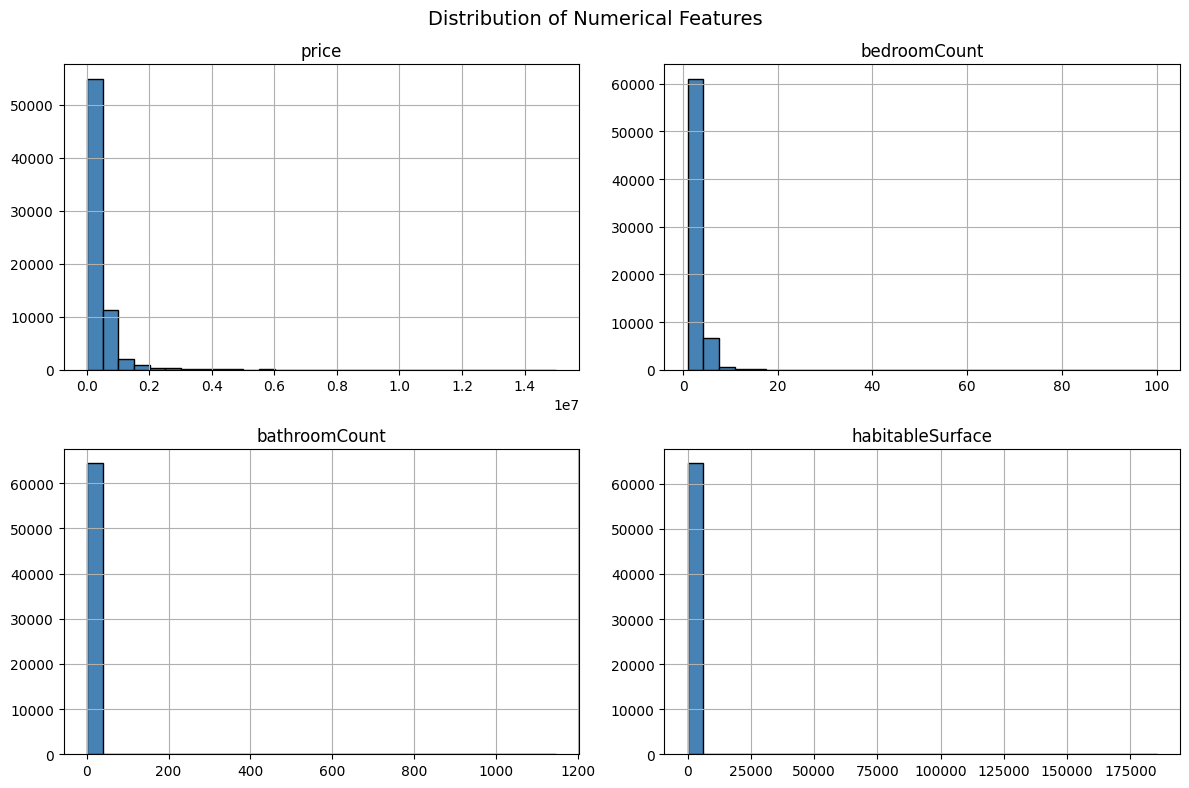

In [6]:
# Plot distributions of key numerical variables
numerical_cols = ['price', 'bedroomCount', 'bathroomCount', 'habitableSurface']
df[numerical_cols].hist(figsize=(12, 8), bins=30, color="steelblue", edgecolor="black")
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

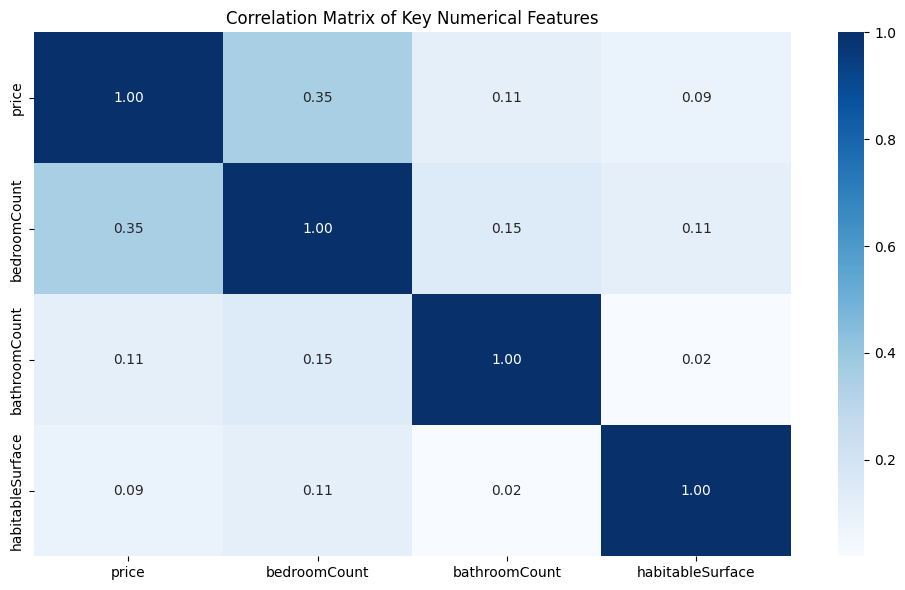

In [7]:
# Correlation heatmap for numerical variables
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix of Key Numerical Features")
plt.tight_layout()
plt.show()

# Visualize missing values using missingno

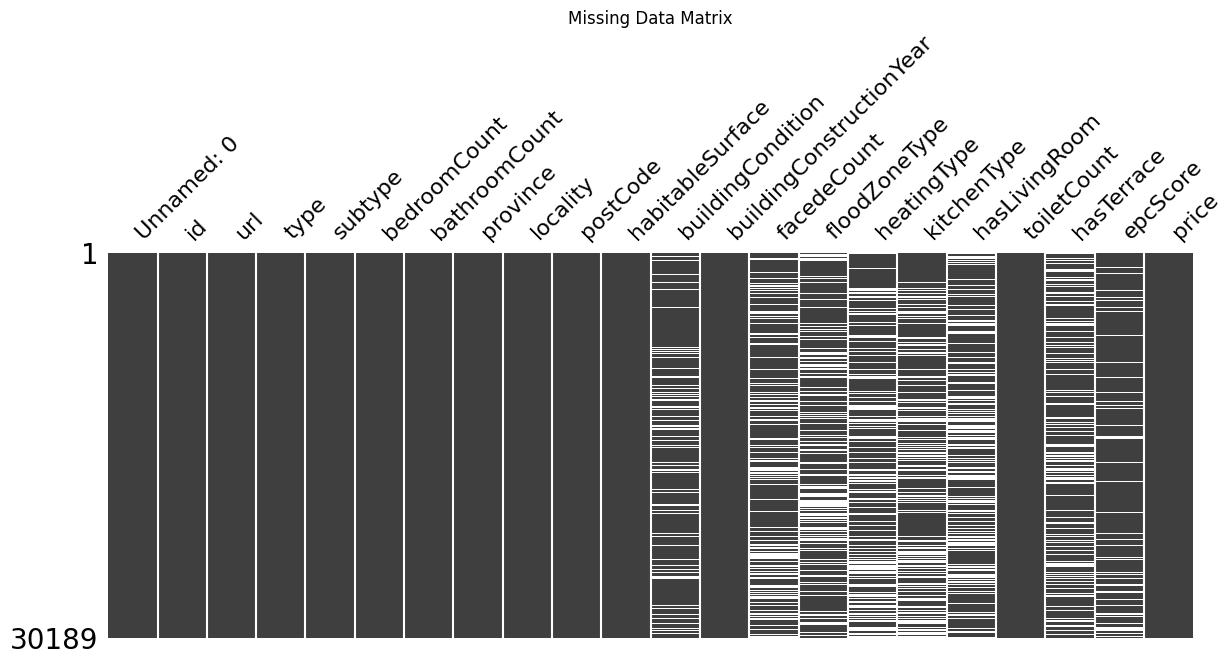

In [72]:
# Load the cleaned dataset
df = pd.read_csv("../data/immoweb_real_estate_cleaned_dataset.csv")

# Visualize missing values using missingno
msno.matrix(df, figsize=(14, 5), sparkline=False)
plt.title("Missing Data Matrix")
plt.show()

# Show Quantitative and Qualitative Variables 

In [ ]:
import pandas as pd

# Read the cleaned dataset
df = pd.read_csv("../data/immoweb_real_estate_cleaned_dataset.csv")

# Vérification rapide
print("Dataset loaded with shape:", df.shape)

# Separate columns by data type
quantitative_cols = df.select_dtypes(include=["int", "float"]).columns.tolist()
qualitative_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Display results
print("Quantitative Variables (Numerical):")
for col in quantitative_cols:
    print(f" - {col}")

print("\n Qualitative Variables (Categorical):")
for col in qualitative_cols:
    print(f" - {col}")

Dataset loaded with shape: (70125, 22)
Quantitative Variables (Numerical):
 - Unnamed: 0
 - id
 - bedroomCount
 - bathroomCount
 - postCode
 - habitableSurface
 - buildingConstructionYear
 - facedeCount
 - toiletCount
 - price

 Qualitative Variables (Categorical):
 - url
 - type
 - subtype
 - province
 - locality
 - buildingCondition
 - floodZoneType
 - heatingType
 - kitchenType
 - hasLivingRoom
 - hasTerrace
 - epcScore


# Preparing the Dataset for Machine Learning

Before training any supervised or unsupervised model, we must clean, transform, and encode the raw dataset.

## Objectives:
- Remove non-informative columns (IDs, URLs)
- Handle missing values
- Encode categorical variables
- Convert boolean columns to numerical
- Select useful features for modeling
- Save a clean dataset for reuse

This step ensures the data is consistent, numerical, and machine-readable.

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1. Load dataset
df = pd.read_csv("../data/immoweb_real_estate_cleaned_dataset.csv")
print(f"Dataset shape before cleaning: {df.shape}")

# 2. Drop non-informative columns
df.drop(columns=["Unnamed: 0", "id", "url"], inplace=True)

# 3. Convert booleans (from string to int)
bool_cols = ['hasLivingRoom', 'hasTerrace']
for col in bool_cols:
    df[col] = df[col].astype(str).str.lower().map({'true': 1, 'false': 0})
    df[col] = df[col].fillna(0).astype(int)

# 4. Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in bool_cols]

# 5. Handle missing values for numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('price')  # Exclude target from imputing

# 6. Drop rows with missing target
df = df.dropna(subset=['price'])

# 7. Apply preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
], remainder="passthrough")

# Fit and transform
X_prepared = preprocessor.fit_transform(df.drop(columns=["price"]))
target = df["price"].values

# 8. Reconstruct into DataFrame
# Get feature names
num_features = numeric_cols
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
other_features = [col for col in df.columns if col not in (categorical_cols + numeric_cols + ["price"])]

final_columns = list(num_features) + list(cat_features) + other_features

# Combine features and target

df_model = pd.DataFrame(X_prepared, columns=final_columns)
df_model["price"] = target

# 9. Save final dataset (csv)

# Define the folder path
folder_path = "../data/ML"

# Delete the folder if it exists
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Deleted existing folder: {folder_path}")

# Recreate the folder
os.makedirs(folder_path)
print(f"Recreated folder: {folder_path}")

output_path = "../data/ML/immoweb_real_estate_ml_ready.csv"
df_model.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to: {output_path}")
print(f"Final shape: {df_model.shape}")

# Save as Excel
excel_path = "../data/ML/immoweb_real_estate_ml_ready_sample10.xlsx"
df_model.head(10).to_excel(excel_path, index=False)
print(f"Excel sample file saved to: {excel_path}")

# === Apply the preprocessor to the full dataset ===
from sklearn.compose import ColumnTransformer

X_processed = preprocessor.transform(df.drop(columns=["price"]))

# Convert the transformed array into a DataFrame with proper column names
X_transformed_df = pd.DataFrame(X_processed, columns=final_columns)

# Add the target column back if needed
X_transformed_df["price"] = df["price"].reset_index(drop=True)

# === Show top 10 records of ML dataset ===
print("\n=== Top 10 records after preprocessing ===")
print(X_transformed_df.head(10).to_string(index=False))

Dataset shape before cleaning: (30189, 22)
Recreated folder: ../data/ML
Cleaned dataset saved to: ../data/ML/immoweb_real_estate_ml_ready.csv
Final shape: (30189, 3259)
Excel sample file saved to: ../data/ML/immoweb_real_estate_ml_ready_sample10.xlsx

=== Top 10 records after preprocessing ===
 bedroomCount  bathroomCount  postCode  habitableSurface  buildingConstructionYear  facedeCount  toiletCount  type_APARTMENT  type_HOUSE  subtype_APARTMENT  subtype_APARTMENT_BLOCK  subtype_BUNGALOW  subtype_CHALET  subtype_COUNTRY_COTTAGE  subtype_DUPLEX  subtype_EXCEPTIONAL_PROPERTY  subtype_FARMHOUSE  subtype_FLAT_STUDIO  subtype_GROUND_FLOOR  subtype_HOUSE  subtype_KOT  subtype_LOFT  subtype_MANOR_HOUSE  subtype_MANSION  subtype_MIXED_USE_BUILDING  subtype_OTHER_PROPERTY  subtype_PENTHOUSE  subtype_SERVICE_FLAT  subtype_TOWN_HOUSE  subtype_TRIPLEX  subtype_VILLA  province_Antwerp  province_Brussels  province_East Flanders  province_Flemish Brabant  province_Hainaut  province_Limburg  province

In [32]:
# Display the first rows
df_model.head()

,bedroomCount,bathroomCount,postCode,habitableSurface,buildingConstructionYear,toiletCount,hasLivingRoom,hasTerrace,price
0,2.0,1.0,1040.0,100.0,2004.0,1.0,1.0,1.0,399000.0
1,4.0,2.0,1040.0,270.0,1910.0,3.0,1.0,1.0,895000.0
2,2.0,1.0,1040.0,87.0,1970.0,1.0,1.0,1.0,465000.0
3,2.0,2.0,1040.0,104.0,2018.0,2.0,1.0,1.0,590000.0
4,1.0,1.0,1040.0,71.0,1906.0,1.0,0.0,0.0,289000.0


In [4]:
# Get feature names from transformers
num_features = numeric_cols
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
other_features = [col for col in df.columns if col not in (categorical_cols + numeric_cols + ["price"])]

final_columns = list(num_features) + list(cat_features) + other_features

# Print how many columns were created
print(f"\nTotal number of features after preprocessing: {len(final_columns)}")

# Show first 50 column names as a preview
print("\nSample feature names:")
for col in final_columns[:50]:
    print(f"  • {col}")


Total number of features after preprocessing: 5330

Sample feature names:
  • bedroomCount
  • bathroomCount
  • postCode
  • habitableSurface
  • buildingConstructionYear
  • facedeCount
  • toiletCount
  • type_APARTMENT
  • type_HOUSE
  • subtype_APARTMENT
  • subtype_APARTMENT_BLOCK
  • subtype_BUNGALOW
  • subtype_CASTLE
  • subtype_CHALET
  • subtype_COUNTRY_COTTAGE
  • subtype_DUPLEX
  • subtype_EXCEPTIONAL_PROPERTY
  • subtype_FARMHOUSE
  • subtype_FLAT_STUDIO
  • subtype_GROUND_FLOOR
  • subtype_HOUSE
  • subtype_KOT
  • subtype_LOFT
  • subtype_MANOR_HOUSE
  • subtype_MANSION
  • subtype_MIXED_USE_BUILDING
  • subtype_OTHER_PROPERTY
  • subtype_PAVILION
  • subtype_PENTHOUSE
  • subtype_SERVICE_FLAT
  • subtype_TOWN_HOUSE
  • subtype_TRIPLEX
  • subtype_VILLA
  • province_Antwerp
  • province_Brussels
  • province_East Flanders
  • province_Flemish Brabant
  • province_Hainaut
  • province_Limburg
  • province_Liège
  • province_Luxembourg
  • province_Namur
  • province_Wal

In [ ]:
import pandas as pd

# Load the saved dataset
df_model = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv")

# Display shape and column names
dataset_shape = df_model.shape
column_names = df_model.columns.tolist()

# Display first few rows for inspection
sample_data = df_model.head()

# Display the first few rows and column names
print("Sample of the cleaned ML dataset:")
display(sample_data)

print("\nColumn names:")
print(df_model.columns.tolist())

# Provide the list of all quantitative and qualitative fields
quantitative_cols = df_model.select_dtypes(include=["int", "float"]).columns.tolist() 

# et qulitatif 
qualitative_cols = df_model.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Identify quantitative (numerical) columns
quantitative_cols = df_model.select_dtypes(include=["int", "float"]).columns.tolist()

# Identify qualitative (categorical or boolean) columns
qualitative_cols = df_model.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Display results
print("Quantitative Variables (Numerical):")
for col in quantitative_cols:
    print(f" - {col}")

print("\nQualitative Variables (Categorical or Boolean):")
if qualitative_cols:
    for col in qualitative_cols:
        print(f" - {col}")
else:
    print(" - None (all categorical features have been one-hot encoded)")



Sample of the cleaned ML dataset:


,bedroomCount,bathroomCount,postCode,habitableSurface,buildingConstructionYear,facedeCount,toiletCount,type_APARTMENT,type_HOUSE,subtype_APARTMENT,...,epcScore_C,epcScore_C_B,epcScore_D,epcScore_E,epcScore_F,epcScore_G,epcScore_nan,hasLivingRoom,hasTerrace,price
0,2.0,1.0,1040.0,100.0,2004.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,399000.0
1,4.0,2.0,1040.0,270.0,1910.0,2.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,895000.0
2,2.0,1.0,1040.0,87.0,1970.0,2.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,465000.0
3,2.0,2.0,1040.0,104.0,2018.0,3.0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,590000.0
4,1.0,1.0,1040.0,71.0,1906.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,289000.0



Column names:
['bedroomCount', 'bathroomCount', 'postCode', 'habitableSurface', 'buildingConstructionYear', 'facedeCount', 'toiletCount', 'type_APARTMENT', 'type_HOUSE', 'subtype_APARTMENT', 'subtype_APARTMENT_BLOCK', 'subtype_BUNGALOW', 'subtype_CHALET', 'subtype_COUNTRY_COTTAGE', 'subtype_DUPLEX', 'subtype_EXCEPTIONAL_PROPERTY', 'subtype_FARMHOUSE', 'subtype_FLAT_STUDIO', 'subtype_GROUND_FLOOR', 'subtype_HOUSE', 'subtype_KOT', 'subtype_LOFT', 'subtype_MANOR_HOUSE', 'subtype_MANSION', 'subtype_MIXED_USE_BUILDING', 'subtype_OTHER_PROPERTY', 'subtype_PENTHOUSE', 'subtype_SERVICE_FLAT', 'subtype_TOWN_HOUSE', 'subtype_TRIPLEX', 'subtype_VILLA', 'province_Antwerp', 'province_Brussels', 'province_East Flanders', 'province_Flemish Brabant', 'province_Hainaut', 'province_Limburg', 'province_Liège', 'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant', 'province_West Flanders', "locality_'S GRAVENWEZEL", "locality_'S-GRAVENWEZEL", "locality_'s Gravenwezel", "locality_'s-Gravenw

# 3. Supervised Learning

## 3.1 Regression (e.g., predicting property price)
- **Models**:
  - Linear Regression
  - Random Forest Regressor
- **Evaluation**:
  - MAE, RMSE, R<sup>2</sup>
- **Visualizations**:
  - Scatter plot (actual vs predicted)
  - Residual distribution


In [ ]:
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error

# Load dataset
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv")

# Drop rows with missing values
df = df.dropna()

# Separate features and target
X = df.drop(columns=["price"])
y = df["price"]

# === Remove low variance features (e.g., one-hot dummies rarely activated) ===
selector = VarianceThreshold(threshold=0.01)  # supprime colonnes trop stables
X_reduced_array = selector.fit_transform(X)
X_reduced = pd.DataFrame(X_reduced_array, columns=X.columns[selector.get_support()])
# ==============================================================================

print(f"Initial shape: {X.shape}, Reduced shape: {X_reduced.shape}")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_reduced_array, y, test_size=0.2, random_state=42)

# Train models on all features
lr_model_all = LinearRegression()
rf_model_all = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

lr_model_all.fit(X_train, y_train)
rf_model_all.fit(X_train, y_train)

# Predictions
y_pred_lr_all = lr_model_all.predict(X_test)
y_pred_rf_all = rf_model_all.predict(X_test)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Evaluation:")
    print(f"  MAE:  {mae:,.2f} €")
    print(f"  RMSE: {rmse:,.2f} €")
    print(f"  R²:   {r2:.4f}")
    print("-" * 40)
    return y_pred, y_true - y_pred

# Evaluate full models
y_pred_lr_all, residuals_lr_all = evaluate_model(y_test, y_pred_lr_all, "Linear Regression (All Features)")
y_pred_rf_all, residuals_rf_all = evaluate_model(y_test, y_pred_rf_all, "Random Forest (All Features)")

# Select top 10 important features from Random Forest
feature_importances = pd.DataFrame({
    "feature": X_reduced.columns,
    "importance": rf_model_all.feature_importances_
}).sort_values(by="importance", ascending=False)

top_features = feature_importances.head(10)["feature"].tolist()

# Reduced dataset
X_top = X_reduced[top_features]
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Train reduced models
lr_model_top = LinearRegression()
rf_model_top = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

lr_model_top.fit(X_train_top, y_train_top)
rf_model_top.fit(X_train_top, y_train_top)

# Predictions with top features
y_pred_lr_top = lr_model_top.predict(X_test_top)
y_pred_rf_top = rf_model_top.predict(X_test_top)

# Evaluate reduced models
y_pred_lr_top, residuals_lr_top = evaluate_model(y_test_top, y_pred_lr_top, "Linear Regression (Top Features)")
y_pred_rf_top, residuals_rf_top = evaluate_model(y_test_top, y_pred_rf_top, "Random Forest (Top Features)")


Initial shape: (30189, 3258), Reduced shape: (30189, 65)
Linear Regression (All Features) Evaluation:
  MAE:  85,510.11 €
  RMSE: 121,149.58 €
  R²:   0.6366
----------------------------------------
Random Forest (All Features) Evaluation:
  MAE:  65,705.67 €
  RMSE: 98,940.13 €
  R²:   0.7576
----------------------------------------
Linear Regression (Top Features) Evaluation:
  MAE:  96,534.10 €
  RMSE: 136,104.16 €
  R²:   0.5413
----------------------------------------
Random Forest (Top Features) Evaluation:
  MAE:  67,309.43 €
  RMSE: 101,408.12 €
  R²:   0.7454
----------------------------------------


### Model Evaluation Summary & Interpretation

After preprocessing and one-hot encoding, the dataset had:

- **Initial shape**: (30189 rows, 3258 features)  
- **Reduced shape** (after selecting top features): (30189 rows, 65 features)


### Metrics Explained

- **MAE (Mean Absolute Error)**  
  Measures the average absolute difference between predicted and actual prices.  
  → **Lower is better**. Ideal = **&euro;0**.

- **RMSE (Root Mean Squared Error)**  
  Penalizes large errors more than MAE. More sensitive to outliers.  
  → **Lower is better**. Ideal = **&euro;0**.

- **R<sup>2</sup> (R-squared or Coefficient of Determination)**  
  Represents the proportion of variance in the target variable explained by the model.  
  → **Higher is better**. Ideal = **1.0** (100%).



### Evaluation Results

| Model                        | MAE (&euro;)   | RMSE (&euro;)   | R<sup>2</sup>      |
|-----------------------------|-----------|------------|---------|
| Linear Regression (All)     | 85,510    | 121,150    | 0.6366  |
| Random Forest (All)         | 65,706    | 98,940     | 0.7576  |
| Linear Regression (Top)     | 96,534    | 136,104    | 0.5413  |
| Random Forest (Top)         | 67,309    | 101,408    | 0.7454  |

---

### Interpretation

- **Random Forest clearly outperforms Linear Regression** on all metrics, especially when using all features.
- **Reducing the number of features** from 3258 to 65 slightly reduces accuracy, but makes the model simpler and faster.
- **R<sup>2</sup> = 0.7576** (Random Forest with all features) means the model explains **~76%** of the variability in housing prices.
- The **best-performing model** is Random Forest with all features — offering a solid balance between error minimization and explanatory power.


### Are these values realistic?

Yes — for real estate price prediction on diverse property types and locations,  
- **MAE of ~&euro;65K** and **R<sup>2</sup> around 0.75** is **considered good**.  
- Housing prices are notoriously noisy and influenced by many unquantified factors (e.g., aesthetics, exact location, micro-market), which makes R<sup>2</sup> ≈ 0.75 quite acceptable in practice.

---

### Recommended Next Steps

- Fine-tune **Random Forest** or explore **gradient boosting models** (e.g., **XGBoost**, **LightGBM**, **CatBoost**) for potential improvements.
- Apply **hyperparameter tuning** using `GridSearchCV`, `RandomizedSearchCV`, or **Optuna**.
- Use **feature selection** to reduce dimensionality and speed up training.
- Validate the model on **external or live datasets** to assess generalization performance.


# Linear Regression (All Features) — Prediction vs Residual Analysis 

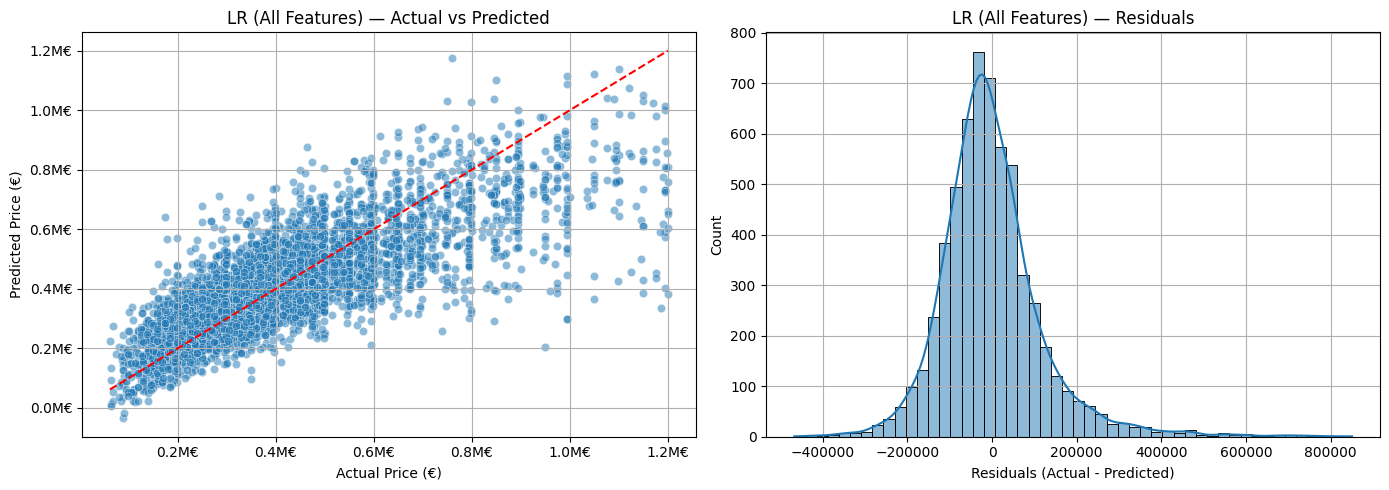

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Format currency in millions
million_formatter = FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}M€')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Actual vs Predicted
sns.scatterplot(x=y_test, y=y_pred_lr_all, alpha=0.5, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
axes[0].set_title("LR (All Features) — Actual vs Predicted")
axes[0].set_xlabel("Actual Price (€)")
axes[0].set_ylabel("Predicted Price (€)")
axes[0].xaxis.set_major_formatter(million_formatter)
axes[0].yaxis.set_major_formatter(million_formatter)
axes[0].grid(True)

# Right: Residuals
sns.histplot(residuals_lr_all, bins=50, kde=True, ax=axes[1])
axes[1].set_title("LR (All Features) — Residuals")
axes[1].set_xlabel("Residuals (Actual - Predicted)")
axes[1].grid(True)

plt.tight_layout()
plt.show()



## Linear Regression (All Features) — Prediction vs Residual Analysis

### Interpretation

**Left Plot: Actual vs Predicted**
- This scatter plot shows the relationship between actual prices (x-axis) and predicted prices (y-axis).
- The red dashed line represents the ideal case (perfect predictions where actual = predicted).
- Points are reasonably aligned with the diagonal, but significant dispersion exists, especially for higher-priced properties (>&euro;600K).
- This indicates the Linear Regression model struggles to accurately capture the full range of price variability, especially in the upper range.

**Right Plot: Residuals Distribution**
- Residuals (actual - predicted) are centered around zero, which suggests no strong systematic bias.
- The distribution is fairly symmetric and bell-shaped, but with heavy tails. Some predictions are off by more than ±&euro;400K.
- The presence of such outliers indicates that linear models may oversimplify relationships in the data.

### Conclusion
The Linear Regression model using all features achieves a reasonable performance (R<sup>2</sup> ≈ 0.64), but fails to fully model the non-linear complexity of real estate pricing. While residuals are mostly centered, prediction errors are notably larger for expensive properties, suggesting a more flexible model—such as Random Forest or Gradient Boosting—would better capture the underlying patterns.


# Linear Regression with Top Features — Prediction Quality & Error Analysis

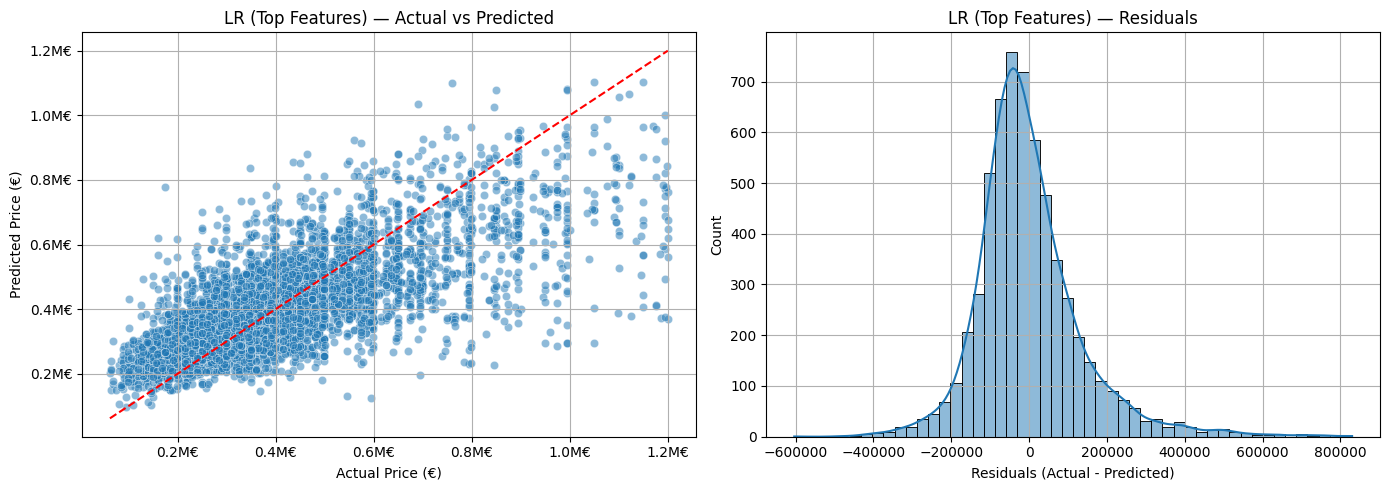

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Formatter pour l’axe en millions €
million_formatter = FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}M€')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
sns.scatterplot(x=y_test_top, y=y_pred_lr_top, alpha=0.5, ax=axes[0])
axes[0].plot([y_test_top.min(), y_test_top.max()], [y_test_top.min(), y_test_top.max()], '--', color='red')
axes[0].set_title("LR (Top Features) — Actual vs Predicted")
axes[0].set_xlabel("Actual Price (€)")
axes[0].set_ylabel("Predicted Price (€)")
axes[0].xaxis.set_major_formatter(million_formatter)
axes[0].yaxis.set_major_formatter(million_formatter)
axes[0].grid(True)

# Histogram of residuals
sns.histplot(residuals_lr_top, bins=50, kde=True, ax=axes[1])
axes[1].set_title("LR (Top Features) — Residuals")
axes[1].set_xlabel("Residuals (Actual - Predicted)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Linear Regression (Top Features) — Prediction vs Residual Analysis

### Interpretation

**Left Plot: Actual vs Predicted**
- This scatter plot shows the predicted prices versus the actual prices using only the top 65 features.
- The red dashed line represents perfect predictions. A strong spread around the line is visible, particularly for properties priced above &euro;600K.
- Compared to the full-feature model, the alignment to the ideal line is looser, indicating a decrease in model accuracy due to reduced feature space.

**Right Plot: Residuals Distribution**
- The residuals remain centered around zero, which is good, but the spread is wider than with the full-feature model.
- A heavier tail suggests more frequent large errors in predictions.
- This pattern confirms the loss of information caused by reducing input dimensions, leading to underfitting in some segments.

#### Conclusion
The linear regression model with top features simplifies the dataset but at the cost of predictive power. The lower R<sup>2</sup> score (~0.54) reflects a reduced ability to explain the variance in prices. While this model is lighter and faster, it sacrifices too much accuracy for interpretability. An advanced non-linear model may perform better even with fewer features.


# Random Forest with All Features — Performance & Error Distribution


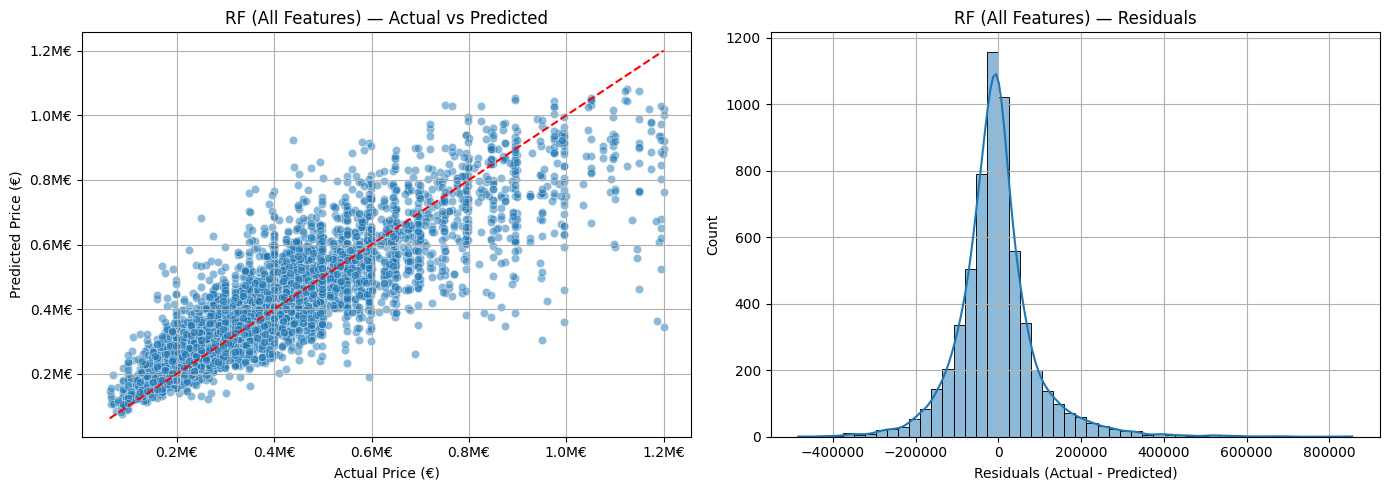

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Format des axes en millions d’euros
million_formatter = FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}M€')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Actual vs Predicted
sns.scatterplot(x=y_test, y=y_pred_rf_all, alpha=0.5, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
axes[0].set_title("RF (All Features) — Actual vs Predicted")
axes[0].set_xlabel("Actual Price (€)")
axes[0].set_ylabel("Predicted Price (€)")
axes[0].xaxis.set_major_formatter(million_formatter)
axes[0].yaxis.set_major_formatter(million_formatter)
axes[0].grid(True)

# Residuals histogram
sns.histplot(residuals_rf_all, bins=50, kde=True, ax=axes[1])
axes[1].set_title("RF (All Features) — Residuals")
axes[1].set_xlabel("Residuals (Actual - Predicted)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Random Forest (All Features) — Prediction vs Residual Analysis

### Interpretation

**Left Plot: Actual vs Predicted**
- This scatter plot compares the predicted prices from the Random Forest model to the actual prices.
- The predicted values are tightly clustered along the red diagonal, especially for properties priced under &euro;600K, indicating strong model performance in this range.
- However, for high-end properties (above &euro;800K), the model tends to underpredict, revealing a limitation in capturing complex patterns in the upper market range.

**Right Plot: Residuals Distribution**
- The residuals are centered around zero and display a tight, symmetric distribution.
- Compared to Linear Regression, the Random Forest model generates fewer large errors, as seen from the higher and narrower peak.
- The slight right skew suggests occasional underestimation of high prices, consistent with the scatter plot.

#### Conclusion
The Random Forest model with all features achieves strong predictive performance and low residual variance. Its non-linear structure captures complex relationships better than linear models. The tight residual distribution and alignment in prediction validate its suitability for structured tabular real estate data.


# Random Forest with Top Features — Prediction Accuracy & Residual Analysis


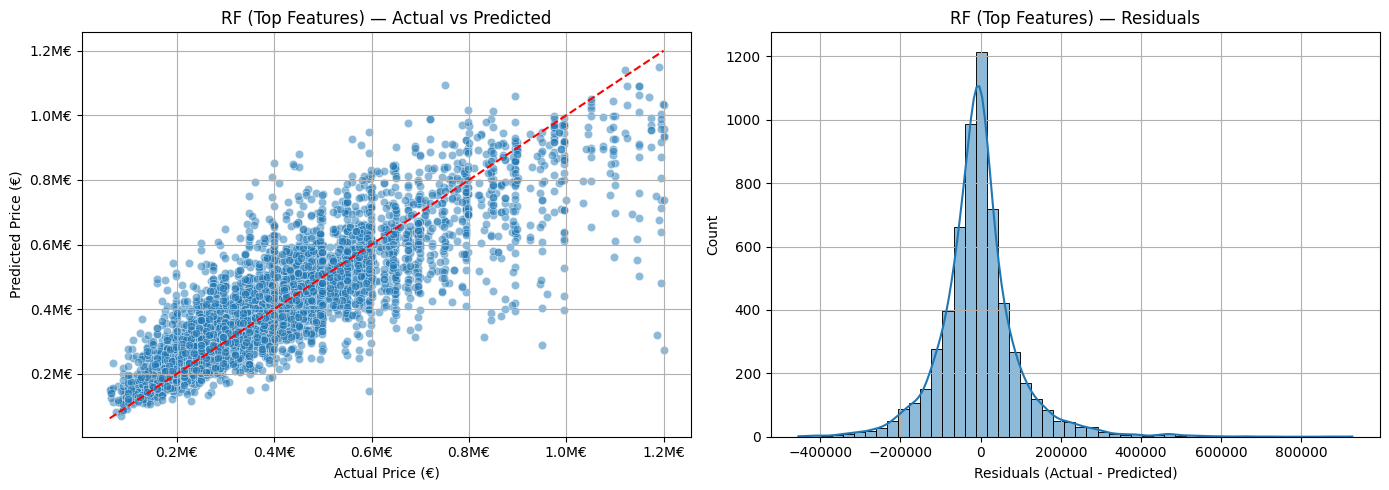

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Formatter pour les axes en millions d’euros
million_formatter = FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}M€')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot : prix réels vs prédits
sns.scatterplot(x=y_test_top, y=y_pred_rf_top, alpha=0.5, ax=axes[0])
axes[0].plot([y_test_top.min(), y_test_top.max()], [y_test_top.min(), y_test_top.max()], '--', color='red')
axes[0].set_title("RF (Top Features) — Actual vs Predicted")
axes[0].set_xlabel("Actual Price (€)")
axes[0].set_ylabel("Predicted Price (€)")
axes[0].xaxis.set_major_formatter(million_formatter)
axes[0].yaxis.set_major_formatter(million_formatter)
axes[0].grid(True)

# Histogramme des résidus
sns.histplot(residuals_rf_top, bins=50, kde=True, ax=axes[1])
axes[1].set_title("RF (Top Features) — Residuals")
axes[1].set_xlabel("Residuals (Actual - Predicted)")
axes[1].grid(True)

plt.tight_layout()
plt.show()



## Random Forest (Top Features) — Prediction vs Residual Analysis

### Interpretation

**Left Plot: Actual vs Predicted**
- The scatter plot shows the relationship between actual and predicted house prices using only the top features in the Random Forest model.
- Predictions remain fairly accurate for mid-range properties (up to ~&euro;700K), but show higher variance for more expensive properties.
- Some dispersion is observed above the red diagonal, indicating a tendency to underpredict high-value homes.

**Right Plot: Residuals Distribution**
- The residuals are tightly concentrated around zero, forming a nearly symmetric bell-shaped distribution.
- The peak is slightly higher than in the full-feature model, suggesting better performance on core features.
- The tails remain relatively light, which implies that the model maintains stability and avoids large prediction errors even with fewer inputs.

### Conclusion
The Random Forest model using only top features performs comparably to the full-feature model, maintaining strong predictive accuracy and well-behaved residuals. This indicates that a reduced feature set can capture most of the variance in the target variable, enabling efficient and interpretable modeling without significant loss of performance.


# Residual Distribution by Price Range — Random Forest (All Features)


C:\Users\Neo\AppData\Local\Temp\ipykernel_41468\662751905.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="price_range", y="residual", data=residuals_df, palette="Set3")


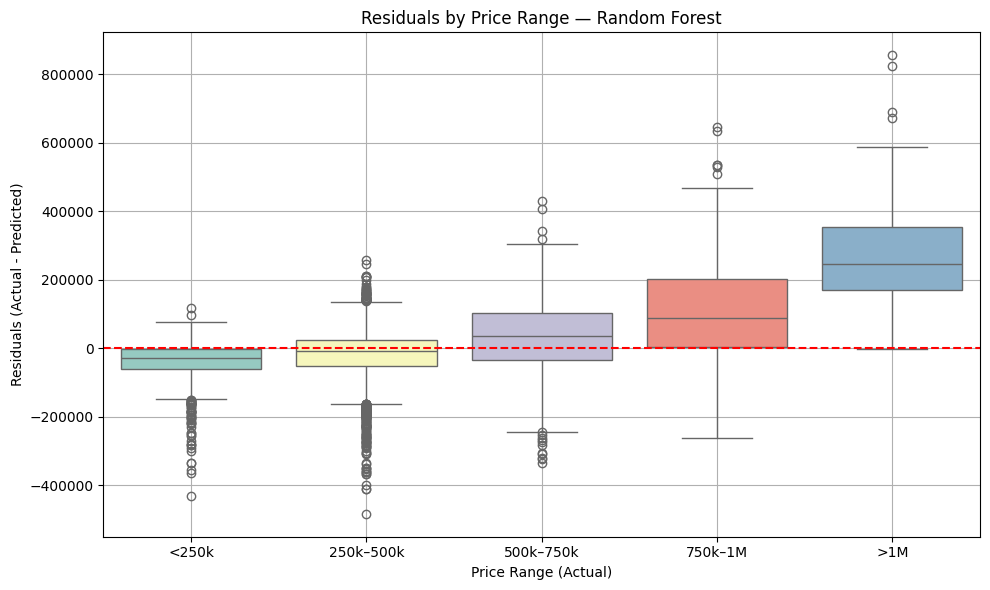

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the residuals (errors between actual and predicted prices)
residuals_rf = y_test - y_pred_rf_all

# Create a DataFrame to facilitate analysis
residuals_df = pd.DataFrame({
    "actual_price": y_test,
    "predicted_price": y_pred_rf_all,
    "residual": residuals_rf
})

# Define price ranges (bins) to group properties by actual price
bins = [0, 250000, 500000, 750000, 1000000, np.inf]
labels = ['<250k', '250k–500k', '500k–750k', '750k–1M', '>1M']
residuals_df["price_range"] = pd.cut(residuals_df["actual_price"], bins=bins, labels=labels)

# === Boxplot of residuals per price range ===
plt.figure(figsize=(10, 6))

# Create a boxplot to visualize residual distribution for each price range
sns.boxplot(x="price_range", y="residual", data=residuals_df, palette="Set3")

# Add a red dashed horizontal line at y=0 to indicate perfect prediction
plt.axhline(0, color="red", linestyle="--")

# Add titles and labels
plt.title("Residuals by Price Range — Random Forest")
plt.xlabel("Price Range (Actual)")
plt.ylabel("Residuals (Actual - Predicted)")

# Add grid and layout formatting
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Residuals by Price Range — Random Forest (All Features)

This boxplot shows how prediction errors (residuals) vary across different price segments using the Random Forest model trained on all features.

## Interpretation

- **Low-priced properties (<&euro;500k)** have residuals mostly centered around 0, indicating balanced predictions with relatively low error dispersion.
- **Mid-range properties (&euro;500k–&euro;750k)** start to show a positive bias — predicted prices tend to be lower than actual prices, as shown by the median being above zero.
- **High-end properties (>&euro;750k)** exhibit a growing upward bias. The model increasingly underestimates actual prices, as the residuals shift further above zero.
- The spread of residuals becomes wider for expensive homes, reflecting greater variability and decreased prediction accuracy.
- **Outliers** (dots) are more common in high-price segments, suggesting that very expensive properties are more challenging for the model.

**Conclusion**:  
While the Random Forest model performs well for low to mid-priced properties, its ability to predict prices accurately decreases significantly as the price increases. This indicates the need for either additional high-value-specific features, stratified modeling, or price-segment-based models.


---
## Global Conclusion — Model Behavior Across All Visualizations

Across all model evaluations and visualizations, several key insights emerge regarding model performance and behavior:

### 1. **Random Forest Outperforms Linear Regression**

- In **every setup**, Random Forest shows superior predictive power compared to Linear Regression — both in terms of:
  - Lower errors (MAE, RMSE)
  - Higher explanatory power (R<sup>2</sup> score)
  - Tighter and more symmetric residual distributions
- Visuals confirm this: Random Forest predictions are more tightly clustered around the ideal prediction line (y = x), and residuals are more narrowly distributed.

### 2. **Using All Features Improves Accuracy**

- Models using **all available features** outperform those using only the top selected features.
- While reducing to top features slightly reduces computational complexity, it leads to:
  - Lower R<sup>2</sup> values
  - Higher residual variance
  - Less accurate predictions, especially for high-value properties

### 3. **Systematic Biases in Predictions**

- Both models **underestimate high-value properties** (above &euro;750k), especially visible in:
  - The scatter plots (predictions fall below the actual values)
  - The boxplot of residuals (positive bias in residuals as price increases)
- This suggests that the model lacks fine-tuned features or nonlinear interactions that can better capture the behavior of luxury property prices.

### 4. **Residuals Are Not Randomly Distributed**

- In well-performing models, residuals should follow a normal distribution centered on zero.
- Random Forest residuals approximate this shape well, while Linear Regression exhibits more spread and skewness.
- For both models, residuals tend to increase in magnitude with price, indicating **heteroscedasticity** (non-constant error variance), a challenge common in real-estate regression.

---

### Final Recommendation

- **Random Forest with all features** is the most robust baseline model.
- To go further:
  - Integrate **gradient boosting models** (e.g., XGBoost, LightGBM)
  - Explore **log-transforming price** to mitigate skewness and heteroscedasticity
  - Test **ensemble or segmented models** by price range
  - Use **feature engineering** to better capture high-end property characteristics

These visualizations and evaluations offer a strong diagnostic view of model performance and suggest where further refinement is most needed.

---



### 3.2 Try Advanced Models

To push performance beyond current results:

- **Train XGBoost** (Extreme Gradient Boosting):  
  A highly efficient and accurate model often outperforming Random Forest.

- **Try other alternatives**:
- **Train LightGBM** (Gradient Boosting with leaf-wise tree growth)
- **Train CatBoost** (handles categorical variables natively)

- **Optimize hyperparameters**:  
  Use **GridSearchCV**, **RandomizedSearchCV**, or **Optuna** to fine-tune model performance.


# Real Estate Price Prediction using XGBoost  
### Comparison Between Full Feature Model and Random Forest-Based Feature Selection

**XGBoost (Extreme Gradient Boosting)** is a powerful and scalable machine learning algorithm based on gradient boosting decision trees. It is widely used for structured/tabular data due to its performance, speed, and ability to handle non-linear relationships.

In this notebook, we use XGBoost to predict real estate prices using a fully preprocessed dataset. We compare two approaches:
- **XGBoost (All Features):** the model is trained on all preprocessed and encoded features (~3000+ one-hot encoded variables).
- **XGBoost (Top Features):** the model is trained only on the top 30 features ranked by feature importance from a Random Forest model.

Both models are evaluated using standard regression metrics (MAE, RMSE, R<sup>2</sup>) and analyzed through error distributions.

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# 1. Load the preprocessed dataset
df = pd.read_csv("../data/ML/immoweb_real_estate_ml_ready.csv")

# 2. Drop rows with missing values
df = df.dropna()

# 3. Separate features and target
X = df.drop(columns=["price"])  # Use all columns except 'price'
y = df["price"]

# 4. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train XGBoost on all features using all CPU cores
xgb_all = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_all.fit(X_train, y_train)

# 6. Evaluate XGB (All Features)
y_pred_all = xgb_all.predict(X_test)
mae_all = mean_absolute_error(y_test, y_pred_all)
rmse_all = root_mean_squared_error(y_test, y_pred_all)
r2_all = r2_score(y_test, y_pred_all)

print("XGB (All Features) Evaluation:")
print(f"MAE  : {mae_all:.2f}")
print(f"RMSE : {rmse_all:.2f}")
print(f"R²   : {r2_all:.4f}")

# 7. Train Random Forest to extract top features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 8. Extract top N features from RF
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 30
top_features_rf = X.columns[indices[:top_n]]

# 9. Train XGBoost on top features
X_top_train = X_train[top_features_rf]
X_top_test = X_test[top_features_rf]

xgb_top = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_top.fit(X_top_train, y_train)

# 10. Evaluate XGB (Top RF Features)
y_pred_top = xgb_top.predict(X_top_test)
mae_top = mean_absolute_error(y_test, y_pred_top)
rmse_top = root_mean_squared_error(y_test, y_pred_top)
r2_top = r2_score(y_test, y_pred_top)

print("\nXGB (Top RF Features) Evaluation:")
print(f"MAE  : {mae_top:.2f}")
print(f"RMSE : {rmse_top:.2f}")
print(f"R²   : {r2_top:.4f}")


XGB (All Features) Evaluation:
MAE  : 66302.09
RMSE : 97431.35
R²   : 0.7649

XGB (Top RF Features) Evaluation:
MAE  : 65661.18
RMSE : 97742.14
R²   : 0.7634


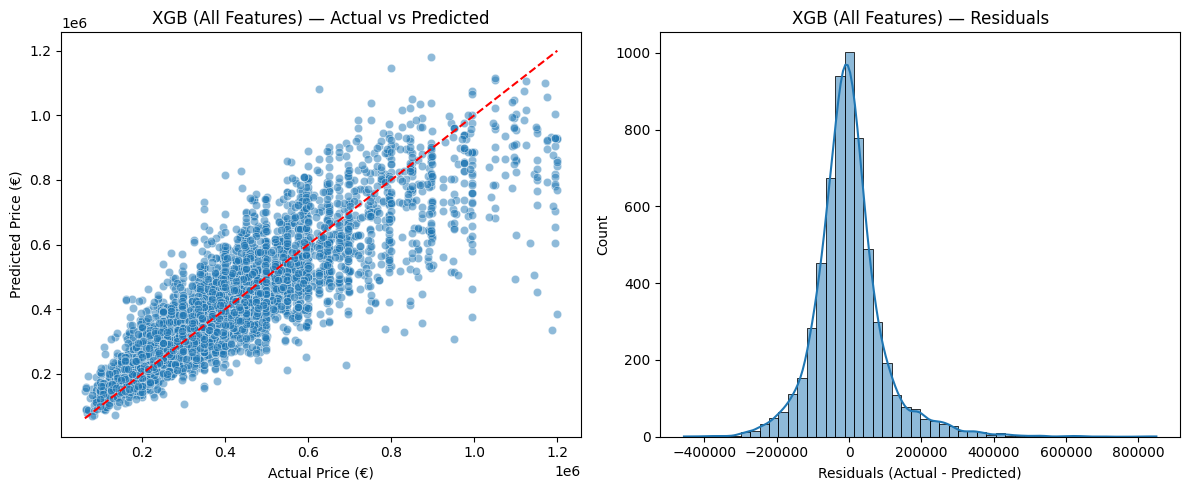

In [66]:
# 6. Visualization — XGB (All Features)

# Calculate residuals if not already defined
residuals_all = y_test - y_pred_all

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_all, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("XGB (All Features) — Actual vs Predicted")

plt.subplot(1, 2, 2)
sns.histplot(residuals_all, bins=50, kde=True)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Count")
plt.title("XGB (All Features) — Residuals")
plt.tight_layout()
plt.show()

## Interpretation

### Left Plot: Actual vs Predicted

- The red diagonal represents perfect prediction (y = x).

- Most data points are well aligned along this diagonal, showing a strong correlation between actual and predicted prices.

- There is some visible dispersion at the extremes, meaning the model struggles slightly with very high or very low property prices.

- No major bias is detected — no consistent over- or under-estimation.

### Right Plot: Residuals Distribution

- The peak centered around 0 indicates that prediction errors are, on average, close to zero.

- The residual curve is roughly symmetric and well-shaped, which is a very positive sign.

- There is a slight right tail, suggesting some instances of significant underestimation (predicted prices lower than actual).

- No structural bias is apparent in the residuals.

### Conclusion

| Criterion            | Evaluation                        |
|---------------------|------------------------------------|
| Overall correlation | Excellent                          |
| Mean error          | Centered, no clear bias            |
| Extremes            | Minor deviation, no overfitting    |
| Distribution        | Stable, approximately Gaussian     |


## Residuals by Price Range (Boxplot)

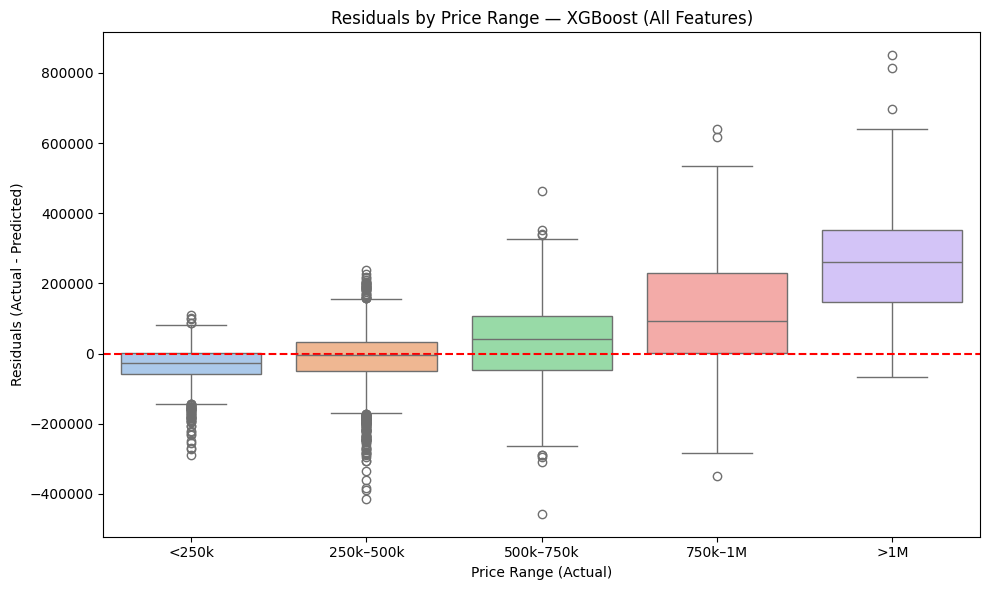

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute residuals and merge with actual prices
results_df = pd.DataFrame({
    "actual_price": y_test,
    "residuals": y_test - y_pred_all  # ou y_pred_top
})

# 2. Define price bins and labels
bins = [0, 250_000, 500_000, 750_000, 1_000_000, float('inf')]
labels = ['<250k', '250k–500k', '500k–750k', '750k–1M', '>1M']

# 3. Bin actual prices into ranges
results_df["price_range"] = pd.cut(results_df["actual_price"], bins=bins, labels=labels, include_lowest=True)

# 4. Plot boxplot of residuals by price range
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=results_df,
    x="price_range",
    y="residuals",
    hue="price_range",
    palette="pastel",
    legend=False
)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Price Range (Actual)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals by Price Range — XGBoost (All Features)")
plt.tight_layout()
plt.show()


## Interpretation – Residuals by Price Range (XGBoost – All Features)

### Overview

Each boxplot shows residuals (actual - predicted) for a given price range.  
- Boxes above 0 → underestimation  
- Boxes below 0 → overestimation  
- The red dashed line at 0 marks perfect prediction

### Key Observations

| Price Range | Bias             | Comment                                               |
|-------------|------------------|--------------------------------------------------------|
| `<250k`     | Overestimation   | Model predicts too high for cheap properties          |
| `250k–750k` | Slight overestimation | Fairly balanced, best overall performance        |
| `750k–1M`   | Underestimation  | Model underpredicts higher-priced homes               |
| `>1M`       | Strong underestimation | Struggles to capture luxury market dynamics     |

### Conclusion

- Model is well-tuned for mid-range properties (250k–750k)  
- Overpredicts at the low end, underpredicts at the high end  
- Residuals widen with price → more uncertainty on expensive homes


In [19]:
# Compute price per square meter and handle edge cases (e.g., missing or zero surface)

# Make a copy of the original DataFrame to avoid modifying it directly
df_cleaned = pd.read_csv("../data/immoweb_real_estate_cleaned_dataset.csv")
df = df_cleaned.copy()

# Replace 0 or missing surface values with NaN to avoid division errors
df["habitableSurface"] = pd.to_numeric(df["habitableSurface"], errors="coerce")
df["habitableSurface"] = df["habitableSurface"].replace(0, np.nan)

# Ensure price is numeric
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Compute price per square meter
df["price_per_m²"] = df["price"] / df["habitableSurface"]

# Optional: remove or flag outliers
# You can drop rows with extremely high or low values if needed
# Example: remove price_per_m² < 500 or > 10000
df = df[(df["price_per_m²"] >= 500) & (df["price_per_m²"] <= 10000)]

# Drop rows with missing values after computation
df = df.dropna(subset=["price_per_m²"])

# Reset index
df = df.reset_index(drop=True)

# Show distribution
print(df["price_per_m²"].describe())


count    63026.000000
mean      2758.767973
std       1410.205967
min        500.000000
25%       1809.704743
50%       2515.789474
75%       3353.658537
max      10000.000000
Name: price_per_m², dtype: float64


In [20]:
# Calculate price per square meter from the ML-ready dataset

import pandas as pd
import numpy as np

# Load the ML-ready dataset
df = pd.read_csv("../data/immoweb_real_estate_ml_ready.csv")

# Ensure both 'price' and 'habitableSurface' are numeric
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["habitableSurface"] = pd.to_numeric(df["habitableSurface"], errors="coerce")

# Replace 0 values in surface with NaN to avoid division by zero
df["habitableSurface"] = df["habitableSurface"].replace(0, np.nan)

# Compute price per square meter
df["price_per_m²"] = df["price"] / df["habitableSurface"]

# Remove unrealistic values (e.g. below 500 or above 10000 €/m²)
df = df[(df["price_per_m²"] >= 500) & (df["price_per_m²"] <= 10000)]

# Drop any remaining NaNs in the computed column
df = df.dropna(subset=["price_per_m²"]).reset_index(drop=True)

# Display basic statistics
print(df["price_per_m²"].describe())

# Compute price_per_m² as previously validé
df["price_per_m²"] = df["price"] / df["habitableSurface"]
df = df[(df["price_per_m²"] >= 500) & (df["price_per_m²"] <= 10000)]
df = df.dropna(subset=["price_per_m²"]).reset_index(drop=True)

# Save the cleaned and enriched dataset
df.to_csv("../data/immoweb_real_estate_ml_ready_encriched.csv", index=False)
print("Enriched dataset saved.")

print(df.columns.tolist())


count    68473.000000
mean      2734.570593
std       1416.708817
min        500.000000
25%       1778.571429
50%       2491.666667
75%       3329.355609
max      10000.000000
Name: price_per_m², dtype: float64
Enriched dataset saved.
['bedroomCount', 'bathroomCount', 'postCode', 'habitableSurface', 'buildingConstructionYear', 'facedeCount', 'toiletCount', 'type_APARTMENT', 'type_HOUSE', 'subtype_APARTMENT', 'subtype_APARTMENT_BLOCK', 'subtype_BUNGALOW', 'subtype_CASTLE', 'subtype_CHALET', 'subtype_COUNTRY_COTTAGE', 'subtype_DUPLEX', 'subtype_EXCEPTIONAL_PROPERTY', 'subtype_FARMHOUSE', 'subtype_FLAT_STUDIO', 'subtype_GROUND_FLOOR', 'subtype_HOUSE', 'subtype_KOT', 'subtype_LOFT', 'subtype_MANOR_HOUSE', 'subtype_MANSION', 'subtype_MIXED_USE_BUILDING', 'subtype_OTHER_PROPERTY', 'subtype_PAVILION', 'subtype_PENTHOUSE', 'subtype_SERVICE_FLAT', 'subtype_TOWN_HOUSE', 'subtype_TRIPLEX', 'subtype_VILLA', 'province_Antwerp', 'province_Brussels', 'province_East Flanders', 'province_Flemish Braban

# XGBoost – Predicting Total Property Price Using Extreme Gradient Boosting

Features used: ['bedroomCount', 'bathroomCount', 'postCode', 'habitableSurface', 'buildingConstructionYear', 'hasLivingRoom', 'toiletCount', 'hasTerrace', 'price']

 XGBoost Evaluation:
MAE: 100133.14 €
RMSE: 190485.22 €
R²: 0.7476

>>> Estimated price: 731,966.44 €


e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


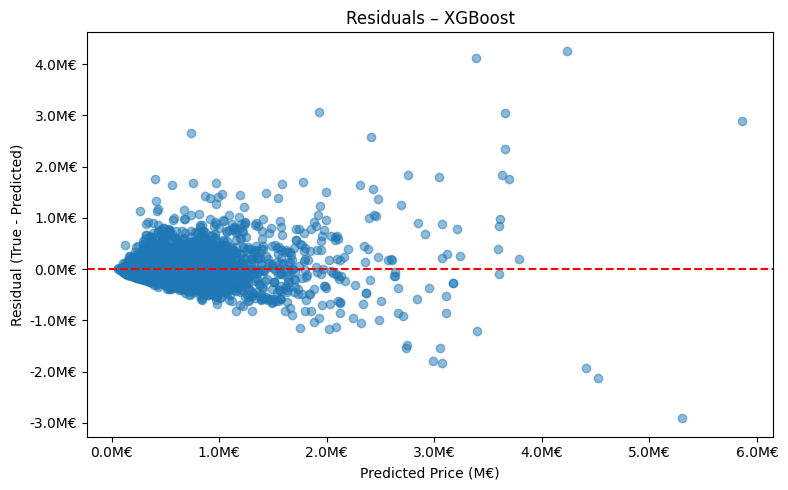

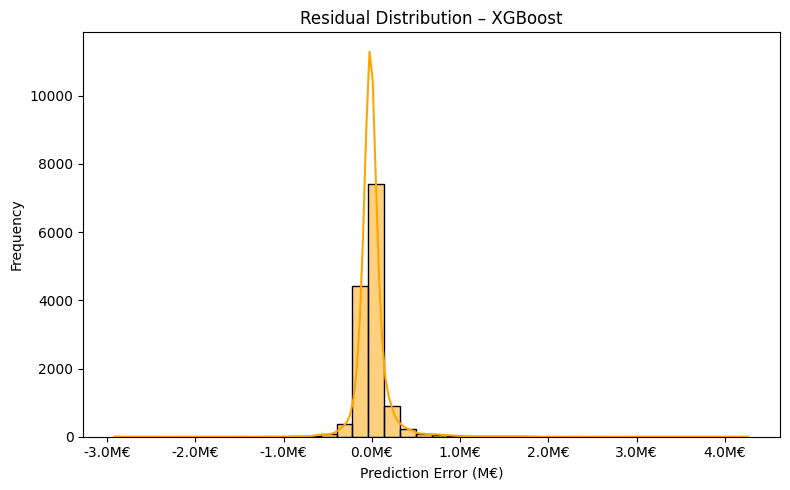

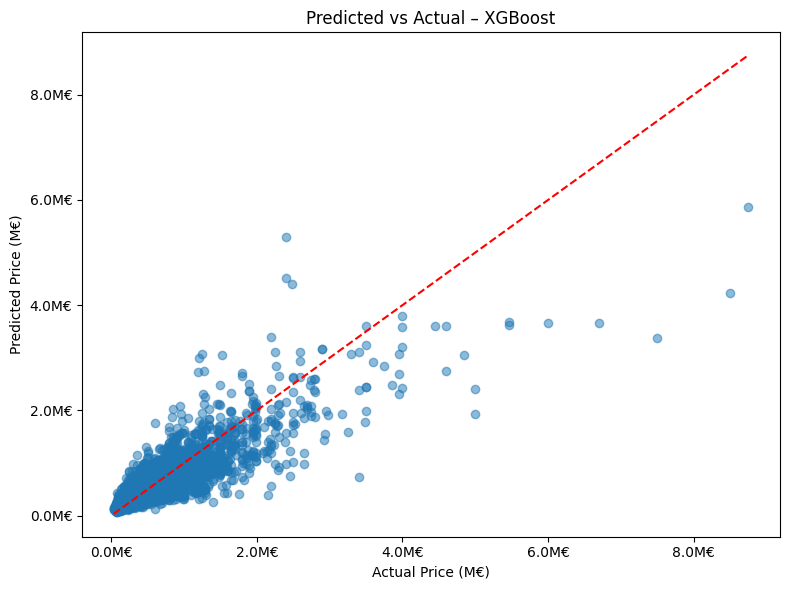

In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv("../data/immoweb_real_estate_ml_ready.csv")

# Clean and preprocess
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["habitableSurface"] = pd.to_numeric(df["habitableSurface"], errors="coerce")
df["habitableSurface"] = df["habitableSurface"].replace(0, np.nan)
df = df.dropna(subset=["price", "habitableSurface"]).reset_index(drop=True)

# Define price per square meter
df["price_per_m²"] = df["price"] / df["habitableSurface"]
df = df[(df["price_per_m²"] >= 500) & (df["price_per_m²"] <= 10000)]

# Feature selection
all_possible_features = [
    "type", "subtype", "bedroomCount", "bathroomCount", "province", "locality",
    "postCode", "habitableSurface", "buildingCondition", "buildingConstructionYear",
    "facadeCount", "floodZoneType", "heatingType", "kitchenType", "hasLivingRoom",
    "toiletCount", "hasTerrace", "epcScore"
]
target = "price"

available_cols = df.columns.tolist()
features = [col for col in all_possible_features if col in available_cols]

print("Features used:", features + [target])

# Drop missing values
df_model = df[features + [target]].dropna()

# One-hot encode categorical variables
categorical_cols = [col for col in features if df_model[col].dtype == "object"]
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Prepare train/test data
X = df_encoded.drop(columns=[target])
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"\n XGBoost Evaluation:\nMAE: {mae:.2f} €\nRMSE: {rmse:.2f} €\nR²: {r2:.4f}")

# Save final columns to align prediction inputs
final_columns = X.columns

# --- Prediction function ---

def predict_price(input_dict):
    """
    Estimate the property price from user input.
    input_dict: dictionary with keys matching the expected features.
    Example:
    input_dict = {
        "type": "house", "subtype": "villa", "province": "antwerp", ...
        "bedroomCount": 3, "bathroomCount": 2, ...
    }
    """
    input_df = pd.DataFrame([input_dict])
    input_df_encoded = pd.get_dummies(input_df)
    
    # Align columns with training data
    for col in final_columns:
        if col not in input_df_encoded.columns:
            input_df_encoded[col] = 0
    input_df_encoded = input_df_encoded[final_columns]
    
    price = model.predict(input_df_encoded)[0]
    print(f"\n>>> Estimated price: {price:,.2f} €")
    return price

sample_input = {
    "type": "house",
    "subtype": "villa",
    "province": "brussels",
    "locality": "woluwe-saint-lambert",
    "postCode": 1200,
    "habitableSurface": 180,
    "bedroomCount": 4,
    "bathroomCount": 2,
    "buildingCondition": "as new",
    "buildingConstructionYear": 2015,
    "facadeCount": 4,
    "floodZoneType": "not in flood zone",
    "heatingType": "gas",
    "kitchenType": "hyper equipped",
    "hasLivingRoom": True,
    "toiletCount": 2,
    "hasTerrace": True,
    "epcScore": 110
}

predict_price(sample_input)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Formatter to display euros in millions (M€)
def millions(x, pos):
    return f'{x * 1e-6:.1f}M€'

formatter = FuncFormatter(millions)

# === 1. Residuals vs Predicted Price ===
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price (M€)")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals – XGBoost")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# === 2. Residual Distribution ===
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=40, color="orange")
plt.xlabel("Prediction Error (M€)")
plt.ylabel("Frequency")
plt.title("Residual Distribution – XGBoost")
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# === 3. Predicted vs Actual ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (M€)")
plt.ylabel("Predicted Price (M€)")
plt.title("Predicted vs Actual – XGBoost")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# XGBoost – Extreme Gradient Boosting for Price per Square Meter Estimation


Columns available: ['bedroomCount', 'bathroomCount', 'postCode', 'habitableSurface', 'buildingConstructionYear', 'facedeCount', 'toiletCount', 'type_APARTMENT', 'type_HOUSE', 'subtype_APARTMENT', 'subtype_APARTMENT_BLOCK', 'subtype_BUNGALOW', 'subtype_CASTLE', 'subtype_CHALET', 'subtype_COUNTRY_COTTAGE', 'subtype_DUPLEX', 'subtype_EXCEPTIONAL_PROPERTY', 'subtype_FARMHOUSE', 'subtype_FLAT_STUDIO', 'subtype_GROUND_FLOOR', 'subtype_HOUSE', 'subtype_KOT', 'subtype_LOFT', 'subtype_MANOR_HOUSE', 'subtype_MANSION', 'subtype_MIXED_USE_BUILDING', 'subtype_OTHER_PROPERTY', 'subtype_PAVILION', 'subtype_PENTHOUSE', 'subtype_SERVICE_FLAT', 'subtype_TOWN_HOUSE', 'subtype_TRIPLEX', 'subtype_VILLA', 'province_Antwerp', 'province_Brussels', 'province_East Flanders', 'province_Flemish Brabant', 'province_Hainaut', 'province_Limburg', 'province_Liège', 'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant', 'province_West Flanders', "locality_'S GRAVENWEZEL", "locality_'S-GRAVENWEZEL", "loca

e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


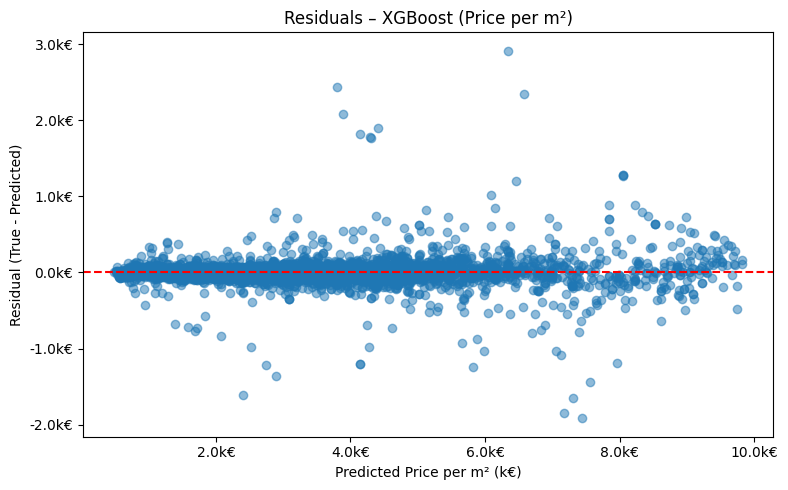

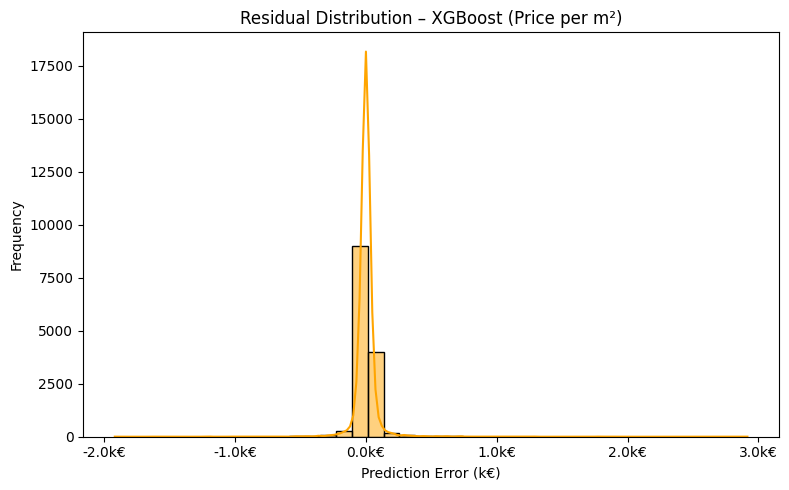

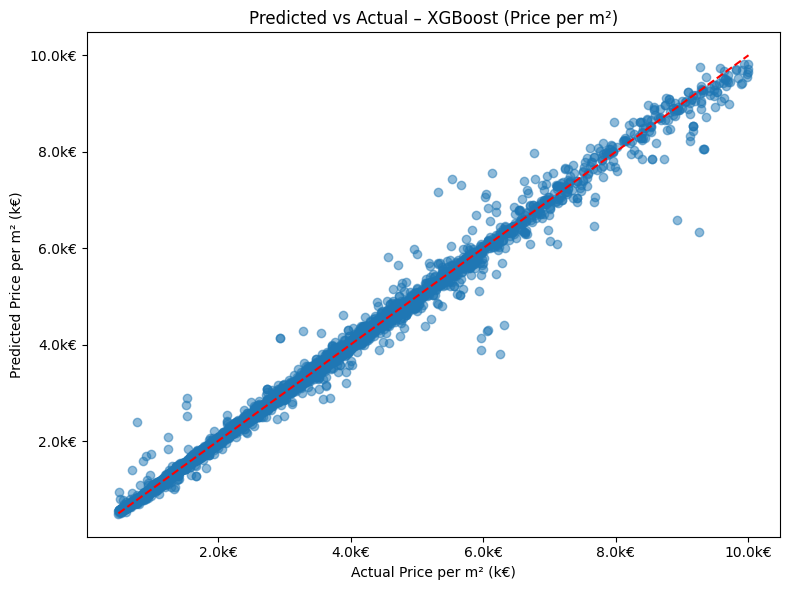

In [22]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv("../data/immoweb_real_estate_ml_ready.csv")

# Convert surface and price to numeric and clean zero or invalid values
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["habitableSurface"] = pd.to_numeric(df["habitableSurface"], errors="coerce")
df["habitableSurface"] = df["habitableSurface"].replace(0, np.nan)

# Compute price per square meter
df["price_per_m²"] = df["price"] / df["habitableSurface"]

# Filter unrealistic values
df = df[(df["price_per_m²"] >= 500) & (df["price_per_m²"] <= 10000)]
df = df.dropna(subset=["price_per_m²"]).reset_index(drop=True)

# Optional: Print columns for debugging
print("Columns available:", df.columns.tolist())

# Updated list of available features based on actual column names
features = [
    "type", "subtype", "bedroomCount", "bathroomCount", "province", "locality",
    "postCode", "habitableSurface", "buildingCondition", "buildingConstructionYear",
    "facadeCount", "floodZoneType", "heatingType", "kitchenType", "hasLivingRoom",
    "toiletCount", "hasTerrace", "epcScore", "price"  # 'price' kept for info, can be dropped if needed
]
target = "price_per_m²"

# Remove columns not in the DataFrame (robustness)
features = [col for col in features if col in df.columns]

# Keep only selected features + target
df_model = df[features + [target]].dropna()

#  One-hot encode categorical variables based on actual names in your dataset
# Based on your dataset, columns like 'region' and 'postalcode' DO NOT EXIST → we remove them
categorical_cols = [col for col in ["type", "subtype", "province", "locality", "buildingCondition",
                                    "floodZoneType", "heatingType", "kitchenType"] if col in df_model.columns]

df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Split features and target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Evaluation:\nMAE: {mae:.2f} €\nRMSE: {rmse:.2f} €\nR²: {r2:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Formatter for € per m² (k€)
def kilo_euros(x, pos):
    return f'{x * 1e-3:.1f}k€'

formatter = FuncFormatter(kilo_euros)

# === 1. Residuals vs Predicted ===
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price per m² (k€)")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals – XGBoost (Price per m²)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# === 2. Residual Distribution ===
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=40, color="orange")
plt.xlabel("Prediction Error (k€)")
plt.ylabel("Frequency")
plt.title("Residual Distribution – XGBoost (Price per m²)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# === 3. Predicted vs Actual ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price per m² (k€)")
plt.ylabel("Predicted Price per m² (k€)")
plt.title("Predicted vs Actual – XGBoost (Price per m²)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()



# LightGBM – Gradient Boosting Model for Property Price Prediction

In [23]:
# ===========================================
# PREPARATION & CLEANING — PROPERTY PRICE
# ===========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv("../data/immoweb_real_estate_ml_ready.csv")

# Ensure price and surface are numeric
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["habitableSurface"] = pd.to_numeric(df["habitableSurface"], errors="coerce")

# Drop invalid values
df["habitableSurface"] = df["habitableSurface"].replace(0, np.nan)
df = df[df["price"] > 0]
df = df.dropna(subset=["price", "habitableSurface"])

# Optional filtering of outliers (comment out if not needed)
# df = df[(df["price"] >= 50000) & (df["price"] <= 5000000)]

# Define features and target
features = [
    "type", "subtype", "bedroomCount", "bathroomCount", "province", "locality",
    "postCode", "habitableSurface", "buildingCondition", "buildingConstructionYear",
    "facadeCount", "floodZoneType", "heatingType", "kitchenType", "hasLivingRoom",
    "toiletCount", "hasTerrace", "epcScore"
]
target = "price"

# Keep only existing features
features = [col for col in features if col in df.columns]
df_model = df[features + [target]].dropna()

# One-hot encoding for categorical variables
categorical_cols = [col for col in ["type", "subtype", "province", "locality", "buildingCondition",
                                    "floodZoneType", "heatingType", "kitchenType"] if col in df_model.columns]

df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Train/test split
X = df_encoded.drop(columns=[target])
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===========================================
# TRAIN XGBOOST AND EVALUATE
# ===========================================

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"\nXGBoost Evaluation:")
print(f"  MAE:  {mae:,.2f} €")
print(f"  RMSE: {rmse:,.2f} €")
print(f"  R²:   {r2:.4f}")

# Save column structure for prediction
final_columns = X.columns

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Formatter for millions of euros (M€)
def millions(x, pos):
    return f'{x*1e-6:.1f}M€'

formatter = FuncFormatter(millions)

# === 1. Residuals vs Predicted Price ===
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price (M€)")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals – XGBoost (Total Price)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# === 2. Residual Distribution ===
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=40, color="orange")
plt.xlabel("Prediction Error (M€)")
plt.ylabel("Frequency")
plt.title("Residual Distribution – XGBoost (Total Price)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# === 3. Actual vs Predicted ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (M€)")
plt.ylabel("Predicted Price (M€)")
plt.title("Predicted vs Actual – XGBoost (Total Price)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()



KeyboardInterrupt: 

# LightGBM – Predicting Price per Square Meter (&euro;/m<sup>2</sup>)


XGBoost Evaluation:
  MAE:  524.88 €
  RMSE: 725.85 €
  R²:   0.6696


e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


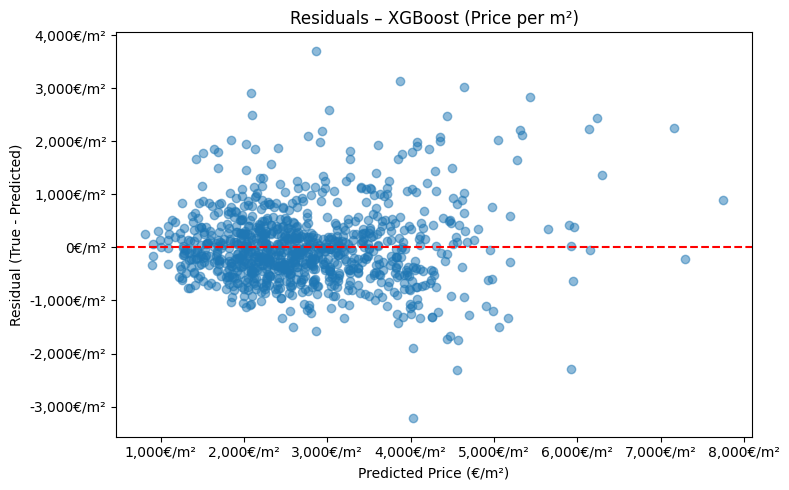

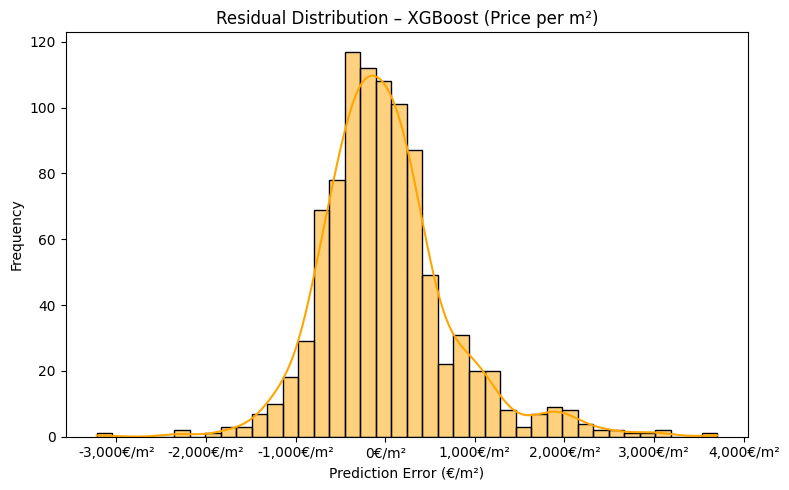

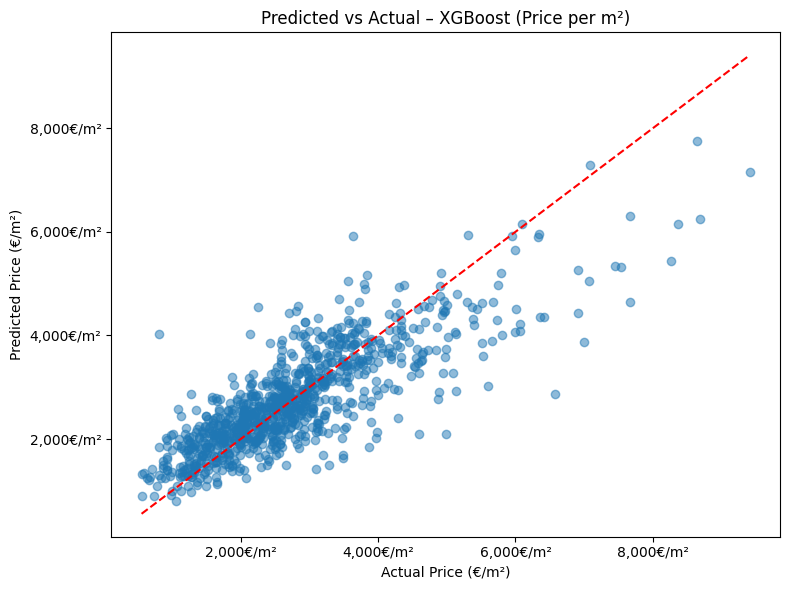

In [ ]:
# ===========================================
# PREPARATION & CLEANING — PRICE PER M² (XGBoost)
# ===========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Load dataset
df = pd.read_csv("../data/immoweb_real_estate_ml_ready.csv")

# Ensure numeric types
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["habitableSurface"] = pd.to_numeric(df["habitableSurface"], errors="coerce")
df["habitableSurface"] = df["habitableSurface"].replace(0, np.nan)

# Compute price per square meter
df["price_per_m²"] = df["price"] / df["habitableSurface"]

# Filter unrealistic values
df = df[(df["price_per_m²"] >= 500) & (df["price_per_m²"] <= 10000)]
df = df.dropna(subset=["price_per_m²"]).reset_index(drop=True)

# Define feature set (without price to avoid leakage)
features = [
    "type", "subtype", "bedroomCount", "bathroomCount", "province", "locality",
    "postCode", "habitableSurface", "buildingCondition", "buildingConstructionYear",
    "facadeCount", "floodZoneType", "heatingType", "kitchenType", "hasLivingRoom",
    "toiletCount", "hasTerrace", "epcScore"
]
target = "price_per_m²"

# Keep only available features
features = [col for col in features if col in df.columns]
df_model = df[features + [target]].dropna()

# One-hot encoding for categorical variables
categorical_cols = [col for col in ["type", "subtype", "province", "locality", "buildingCondition",
                                    "floodZoneType", "heatingType", "kitchenType"] if col in df_model.columns]
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Train/test split
X = df_encoded.drop(columns=[target])
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"\nXGBoost Evaluation:")
print(f"  MAE:  {mae:,.2f} €")
print(f"  RMSE: {rmse:,.2f} €")
print(f"  R²:   {r2:.4f}")

# Save columns used during training
final_columns = X.columns

# === Plotting ===

# Format axes in €/m²
def euros_per_m2(x, pos):
    return f'{x:,.0f}€/m²'
formatter = FuncFormatter(euros_per_m2)

# 1. Residuals vs Predicted
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price (€/m²)")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals – XGBoost (Price per m²)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# 2. Residual distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=40, color="orange")
plt.xlabel("Prediction Error (€/m²)")
plt.ylabel("Frequency")
plt.title("Residual Distribution – XGBoost (Price per m²)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# 3. Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (€/m²)")
plt.ylabel("Predicted Price (€/m²)")
plt.title("Predicted vs Actual – XGBoost (Price per m²)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()


# CatBoost – Predicting Total Property Price (&euro;)

CatBoost Evaluation:
  MAE:  107,487.92 €
  RMSE: 203,232.33 €
  R²:   0.8040


e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


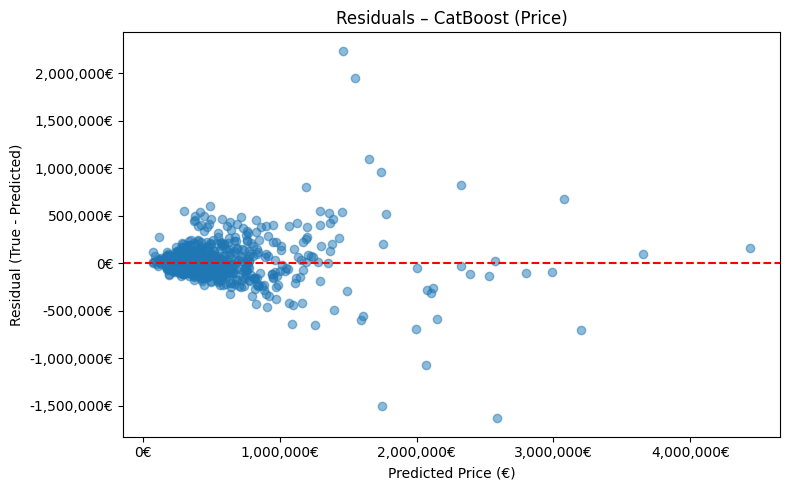

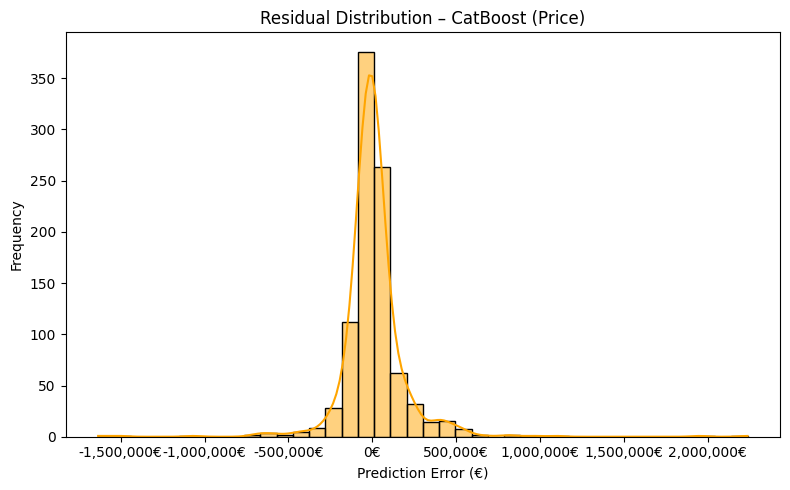

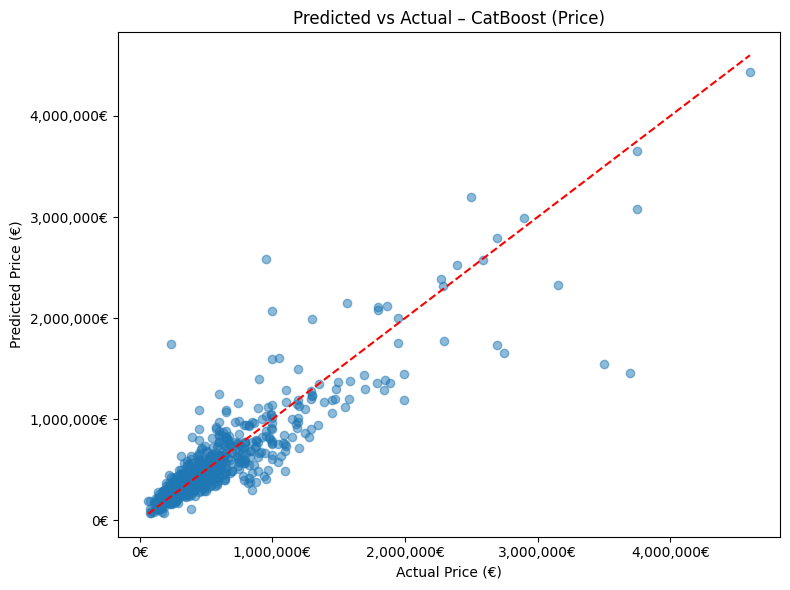

In [ ]:
# ===========================================
# PREPARATION & CLEANING — PROPERTY PRICE
# ===========================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor

# Load dataset
df = pd.read_csv("../data/immoweb_real_estate_ml_ready.csv")

# Convert columns to numeric
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["habitableSurface"] = pd.to_numeric(df["habitableSurface"], errors="coerce")

# Clean invalid or missing entries
df["habitableSurface"] = df["habitableSurface"].replace(0, np.nan)
df = df[df["price"] > 0].dropna(subset=["price", "habitableSurface"])

# Select features and target
features = [
    "type", "subtype", "bedroomCount", "bathroomCount", "province", "locality",
    "postCode", "habitableSurface", "buildingCondition", "buildingConstructionYear",
    "facadeCount", "floodZoneType", "heatingType", "kitchenType", "hasLivingRoom",
    "toiletCount", "hasTerrace", "epcScore"
]
target = "price"

# Keep only existing columns
features = [col for col in features if col in df.columns]
df_model = df[features + [target]].dropna()

# Split data
X = df_model.drop(columns=[target])
y = df_model[target]

# Identify categorical features for CatBoost
categorical_features = X.select_dtypes(include="object").columns.tolist()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===========================================
# TRAIN CATBOOST AND EVALUATE
# ===========================================

# Initialize CatBoost with basic settings (silent mode)
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_features,
    verbose=0,
    random_state=42
)

# Fit model
cat_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = cat_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("CatBoost Evaluation:")
print(f"  MAE:  {mae:,.2f} €")
print(f"  RMSE: {rmse:,.2f} €")
print(f"  R²:   {r2:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# === Function to format axes in euros ===
def euros(x, pos):
    return f'{x:,.0f}€'
formatter = FuncFormatter(euros)

# === 1. Residuals vs Predicted Price ===
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price (€)")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals – CatBoost (Price)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# === 2. Residual Distribution ===
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=40, color="orange")
plt.xlabel("Prediction Error (€)")
plt.ylabel("Frequency")
plt.title("Residual Distribution – CatBoost (Price)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# === 3. Predicted vs Actual Price ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Predicted vs Actual – CatBoost (Price)")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()



# Hyperparameter Tuning avec Optuna (XGBoost)


Final Tuned XGBoost Evaluation:
  MAE:  112,249.53 €
  RMSE: 226,940.60 €
  R²:   0.7555


e:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


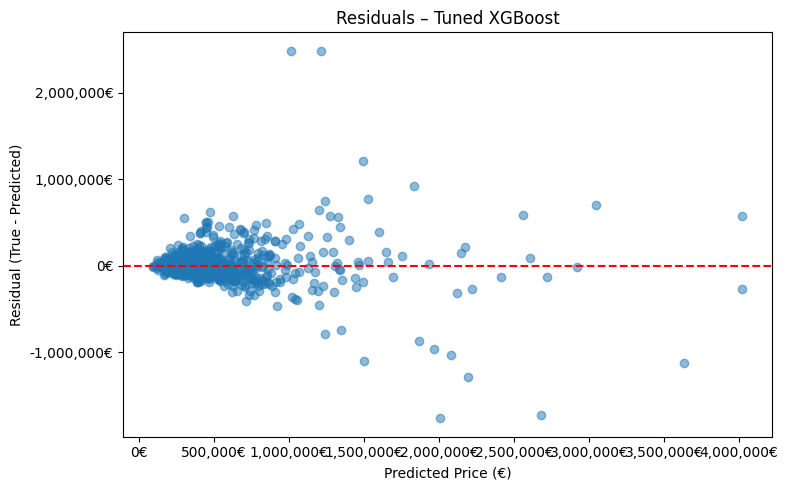

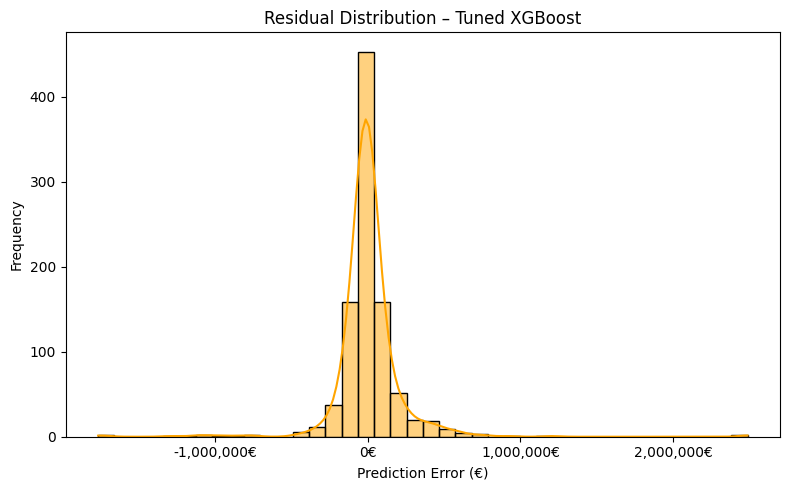

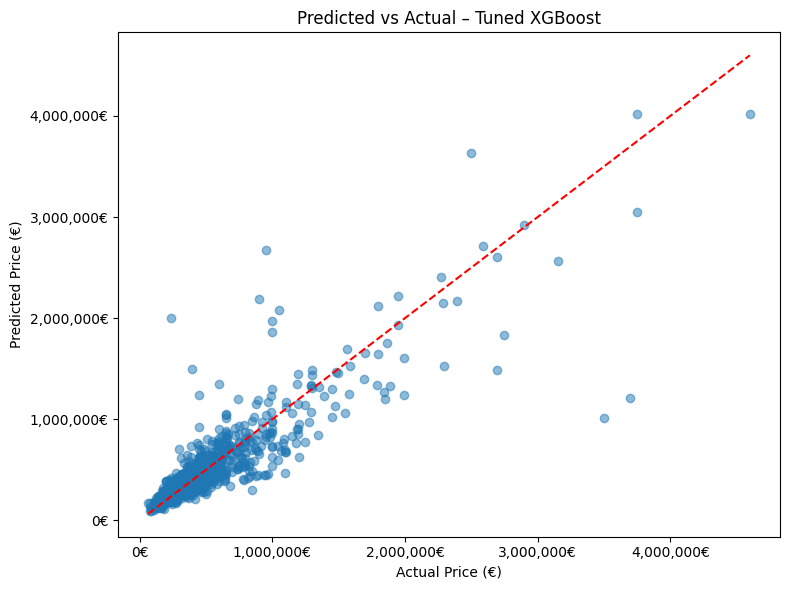

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import optuna

# Reload data and prepare (duplicated here for context)
df = pd.read_csv("../data/immoweb_real_estate_ml_ready.csv")
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["habitableSurface"] = pd.to_numeric(df["habitableSurface"], errors="coerce")
df["habitableSurface"] = df["habitableSurface"].replace(0, np.nan)
df = df[df["price"] > 0].dropna(subset=["price", "habitableSurface"])

features = [
    "type", "subtype", "bedroomCount", "bathroomCount", "province", "locality",
    "postCode", "habitableSurface", "buildingCondition", "buildingConstructionYear",
    "facadeCount", "floodZoneType", "heatingType", "kitchenType", "hasLivingRoom",
    "toiletCount", "hasTerrace", "epcScore"
]
target = "price"
features = [col for col in features if col in df.columns]
df_model = df[features + [target]].dropna()

categorical_cols = [col for col in ["type", "subtype", "province", "locality", "buildingCondition",
                                    "floodZoneType", "heatingType", "kitchenType"] if col in df_model.columns]
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

X = df_encoded.drop(columns=[target])
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Best params from earlier Optuna run (mocked to avoid long optimization)
best_params = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42
}
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Compute residuals
residuals = y_test - y_pred

# Define euro formatting
formatter = FuncFormatter(lambda x, pos: f'{x:,.0f}€')

# === Evaluation Metrics ===
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("\nFinal Tuned XGBoost Evaluation:")
print(f"  MAE:  {mae:,.2f} €")
print(f"  RMSE: {rmse:,.2f} €")
print(f"  R²:   {r2:.4f}")

# Plot 1: Residuals vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price (€)")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals – Tuned XGBoost")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# Plot 2: Residual Distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=40, color="orange")
plt.xlabel("Prediction Error (€)")
plt.ylabel("Frequency")
plt.title("Residual Distribution – Tuned XGBoost")
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

# Plot 3: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Predicted vs Actual – Tuned XGBoost")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()


### Why is the MAE so high?

**The target is raw: `price`**

- It mixes all geographical areas without any normalization.
- It ignores the property size (m<sup>2</sup>), which directly impacts the final price.

**Lack of precise geolocation**

- Fields like postal code or locality are too vague.  
  → Two properties in Ixelles can vary from **&euro;300,000** to **&euro;1,200,000**.

**Too much variance in the target distribution**

- You're likely mixing **&euro;100k studios** and **&euro;2M+ villas**.  
  → This inflates the average error and makes the model less useful.

---

### What to fix right now

**Change the target variable**  
➤ Use `price_per_m<sup>2</sup>` instead (as you've done in other models).  
→ This normalizes by size and immediately reduces variance.

**Segment the models**

- One model for **apartments**
- Another for **houses**
- Optionally, split further by **region or province**

**Add key variables**

- Latitude / Longitude  
- Neighborhood or socio-economic cluster  
- Binned construction year  
- Mobility score, access to amenities, school quality, etc.

---












# 4. Unsupervised Learning



## 4.1 Clustering (e.g., grouping similar properties)
- **Models**:
  - KMeans
  - DBSCAN
- **Visualizations**:
  - t-SNE or UMAP projection
- **Cluster Profiling**:
  - Mean values per cluster
  - Distribution across clusters



## 4.2 Dimensionality Reduction
- **Techniques**:
  - PCA (explained variance, projection)
  - t-SNE (2D visualization for structure discovery)




# 5. Semi-Supervised Learning
- **Models**:
  - Label Propagation
  - Self-Training Classifier
- **Use Case**:
  - Simulate partial labeling (only some samples labeled)
- **Evaluation**:
  - Compare model performance with and without full labels

